# Plotting


In [66]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import pandas as pd
import simpy
import random
from scipy import stats
import warnings

def data_loader(name):
    """ Given a csv  file containg it returns the data as {'x': lambda_ / mus, 'waitingtimes': waitingtimes, 'confidences': confidences, 'n_simulations': n_simulations} """
    df = pd.read_csv(name)
    df.set_index('Unnamed: 0', inplace= True)
    return df.to_dict()

In [67]:
class FiFoServers:
    def __init__(self, env, mu, num_servers):
        self.mu = mu
        self.server = simpy.Resource(env, capacity=num_servers)
        self.processing_times = []
        self.final_arrival = 1
        self.N = 0
        self.queue_length = 0

class SJFServers:
    def __init__(self, env, mu, num_servers):
        self.mu = mu
        self.server = simpy.PriorityResource(env, capacity=num_servers)
        self.processing_times = []
        self.final_arrival = 1
        self.N = 0
        self.queue_length = 0

def task(name, env, servers, processing_time, waiting_times, print_tasks):

    # A task arrives at the server
    start_time = env.now
    if print_tasks:
        print(f'Task {name} arriving at {start_time}')
    
    servers.final_arrival = start_time
    servers.N += 1
    servers.queue_length += 1

    # Request task to server
    with servers.server.request() as req:

        # Once there is availability at the server, initiate task
        yield req
        end_time = env.now
        servers.queue_length -= 1
  
        if print_tasks:
            print(f'Server starts processing {name} at {end_time}')

        yield env.timeout(processing_time)

        if print_tasks:
            print(f'Server done processing {name} at {env.now}')

        waiting_times.append(end_time - start_time)
        servers.processing_times.append(processing_time)


def get_confidence(data, p=0.95):
    """
    Calculate the mean and confidence interval of a dataset for a given confidence level.

    Parameters:
    - data (array-like): Input data.
    - p (float, optional): Confidence level (default is 0.95).

    Returns:
    tuple: A tuple containing the mean and the confidence interval.
    """

    mean = np.mean(data)
    n = len(data)
    lamb = stats.t.ppf((1 + p) / 2, n - 1)
    sigma = np.std(data)
    confidence = (lamb * sigma / np.sqrt(n))
    return mean, confidence

In [68]:
def run_simulation(num_servers, mu, lambda_, N, scheduler, print_statistics, mode):
    env = simpy.Environment()

    # Use either First-in First-out or Shortest Job First scheduling
    if scheduler.lower() == 'fifo':
        servers = FiFoServers(env, mu, num_servers)
    elif scheduler.lower() == 'sjf':
        servers = SJFServers(env, mu, num_servers)

    waiting_times = []

    # Generate tasks
    
    if mode == 'deter':
        env.process(task_generator_deter(env, servers, N, lambda_ * num_servers, waiting_times))
        env.run()
    elif mode == 'long tail':
        env.process(task_generator_long_tail(env, servers, N, lambda_ * num_servers, waiting_times))
        env.run()
    elif mode == 'Markov':
        env.process(task_generator(env, servers, N, lambda_ * num_servers, waiting_times))
        env.run()
    
    # Calculate statistics on waiting times
    waiting_times_array = np.array(waiting_times)
    confidence_level = 0.95

    # Calculate confidence interval of waiting time
    mean_waitingtime, confidence_waitingtime = get_confidence(waiting_times_array, confidence_level)

    # Calculate statistics on processing times
    processing_times_array = np.array(servers.processing_times)

    # Calculate confidence interval of processing rate
    mean, confidence = get_confidence(processing_times_array, confidence_level)

    if print_statistics:

        std_waiting_time = np.std(waiting_times_array)
        confidence_interval = (mean_waitingtime - confidence_waitingtime, mean_waitingtime + confidence_waitingtime)

        print(f"{num_servers} server(s):")
        print(f"Average Waiting Time: {mean_waitingtime}")
        print(f"Standard Deviation of Waiting Time: {std_waiting_time}")
        print(f"Confidence Interval (95%): {confidence_interval}\n")
        
        processing_rates_array = 1 / processing_times_array[processing_times_array > 0]
        std_processing_rate = np.std(processing_rates_array)
        confidence_interval = (1 / (mean + confidence), 1 / (mean - confidence))

        print(f"Average Processing Rate of server: {1 / mean}")
        print(f"Standard deviation of Processing Rate {std_processing_rate}")
        print(f"Confidence Interval (95%): {confidence_interval}\n")

        # Print statistics on arrivals
        print(f"Time of final arrival: {servers.final_arrival}")
        print(f"Number of arrivals: {servers.N}")
        print(f"Average arrivals per timestep: {servers.N / servers.final_arrival}\n\n")

    return mean_waitingtime, confidence_waitingtime


In [69]:
def generate_waitingtimes(lambda_, mus, N, num_servers_list, scheduler, mode, n=1):
    """Generates data for the average waiting times with different servers and different system loads."""
    
    ## Ignore division by 0 warnings
    warnings.filterwarnings("ignore", category=RuntimeWarning) 

    data = {}

    # Loop over number of servers
    for num_servers in num_servers_list:
        waitingtimes = []
        confidences = []

        # Loop over different values for rho by varying mu
        for mu in mus:
            waiting_times_for_simulations = []

            # Run simulation multiple times
            for _ in range(n):
                mean_waitingtime, confidence_waitingtime = run_simulation(num_servers, mu, lambda_, N, scheduler, False, mode)
                if n == 1:
                    confidences.append(confidence_waitingtime)
                    waitingtimes.append(mean_waitingtime)
                else:
                    waiting_times_for_simulations.append(mean_waitingtime)

            if n > 1:
                # Calculate mean and confidence interval using the get_confidence function
                mean, confidence = get_confidence(waiting_times_for_simulations)
                waitingtimes.append(mean)
                confidences.append(confidence)

        data[num_servers] = {'x': lambda_ / mus, 'waitingtimes': waitingtimes, 'confidences': confidences}

    return data

In [70]:
def task_generator(env, servers, N, lambda_, waiting_times, print_tasks=False):

    # Generate N tasks
    for i in range(N):
        
        # Calculate time at server by Poisson process, not sure if necessary
        processing_time = random.expovariate(servers.mu)

        # Create task
        env.process(task(i, env, servers, processing_time, waiting_times, print_tasks))

        # Calculate time until next task by Poisson process, not sure if necessary
        next_arrival = random.expovariate(lambda_)
        yield env.timeout(next_arrival)

def task_generator_long_tail(env, servers, N, lambda_, waiting_times, print_tasks=False):
    
    # Generate 0.75#N tasks with a processing time of 5*mu
    for i in range(N):

        if i >= N*0.75:
            processing_time = random.expovariate(servers.mu)
        else:
            processing_time = random.expovariate(0.4*servers.mu)
        # Create task
        env.process(task(i, env, servers, processing_time, waiting_times, print_tasks))

        # Calculate time until next task by Poisson process, not sure if necessary
        next_arrival = random.expovariate(lambda_)
        yield env.timeout(next_arrival)

def task_generator_deter(env, servers, N, lambda_, waiting_times, print_tasks=False):
    
    for i in range(N):
        processing_time = 1/servers.mu

        # Create task
        env.process(task(i, env, servers, processing_time, waiting_times, print_tasks))

        # Calculate time until next task by Poisson process, not sure if necessary
        next_arrival = random.expovariate(lambda_)
        yield env.timeout(next_arrival)

## Finding N and n

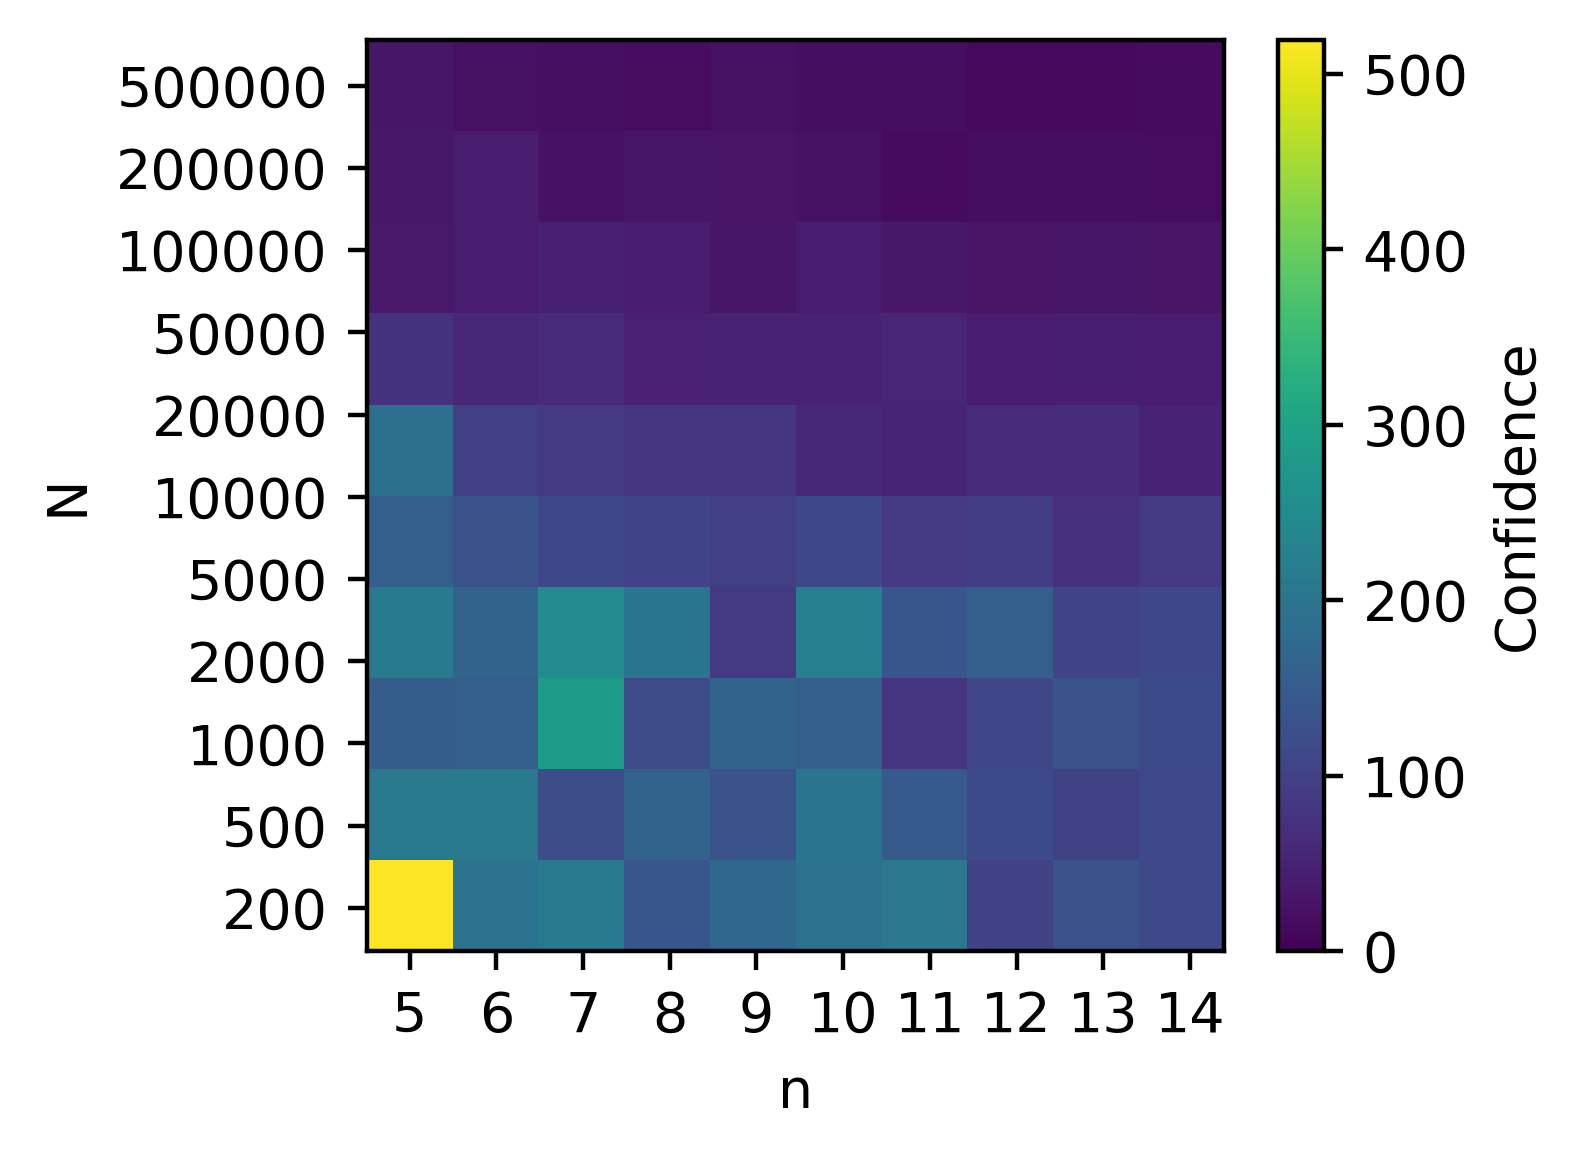

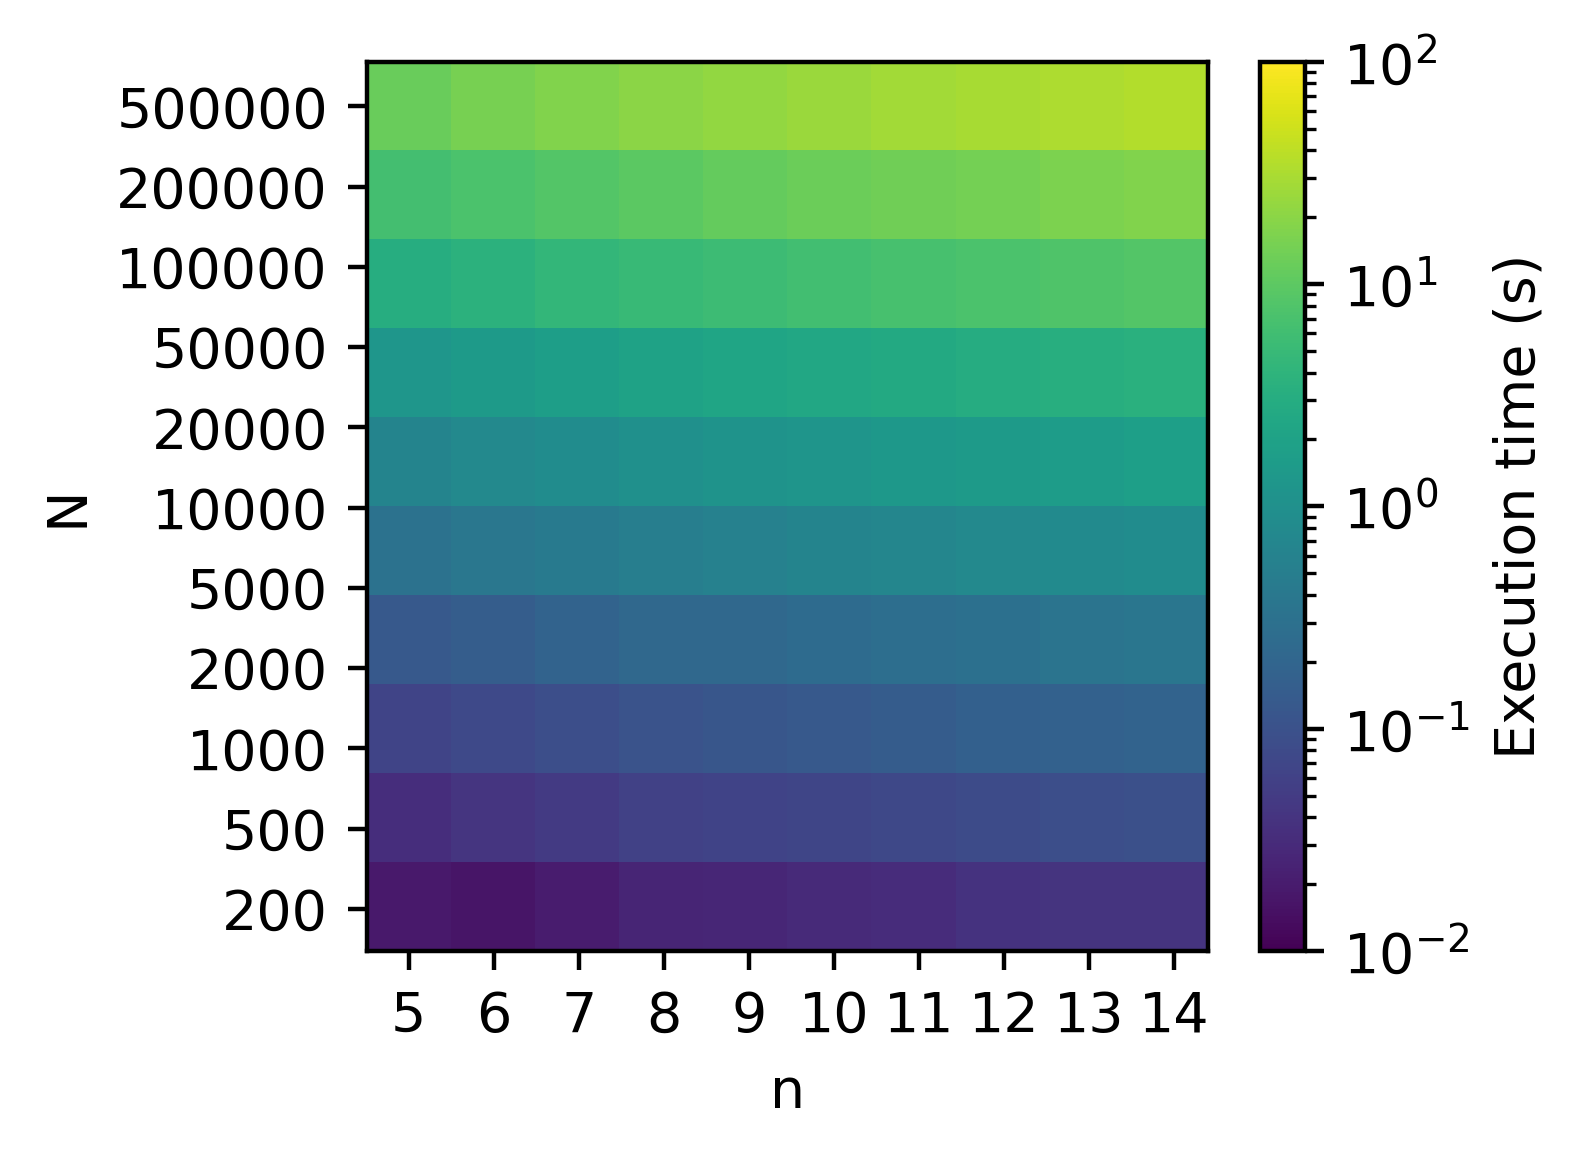

In [36]:
heatmap_data = np.loadtxt('heatmap_data.txt')
plt.figure(figsize=(4,3),dpi=400)
plt.imshow(heatmap_data, cmap='viridis', origin='lower', extent=[ns[0], ns[-1], Ns[0], Ns[-1]], aspect='auto', vmin=0)

colorbar = plt.colorbar(label=f'Confidence')

xticklabels = [str(x) for x in ns]
yticklabels = [str(y) for y in Ns]
plt.xlabel('n')
plt.ylabel('N')
plt.yticks(np.linspace(25_000, Ns[-1], len(Ns)) * 0.95, yticklabels)
plt.xticks(ns * 0.91 + 0.9, xticklabels)
plt.tight_layout()
plt.savefig('heatmap_waitingime.png')
plt.show()

data_times = np.loadtxt('heatmap_times.txt')
plt.figure(figsize=(4,3),dpi=400)
plt.imshow(data_times, cmap='viridis', origin='lower', extent=[ns[0], ns[-1], Ns[0], Ns[-1]], aspect='auto', norm=LogNorm(0.01, 100))

colorbar = plt.colorbar(label=f'Execution time (s)')

xticklabels = [str(x) for x in ns]
yticklabels = [str(y) for y in Ns]
plt.xlabel('n')
plt.ylabel('N')
plt.yticks(np.linspace(25_000, Ns[-1], len(Ns)) * 0.95, yticklabels)
plt.xticks(ns * 0.91 + 0.9, xticklabels)
plt.tight_layout()
plt.savefig('heatmap_time.png')
plt.show()

## Question 2

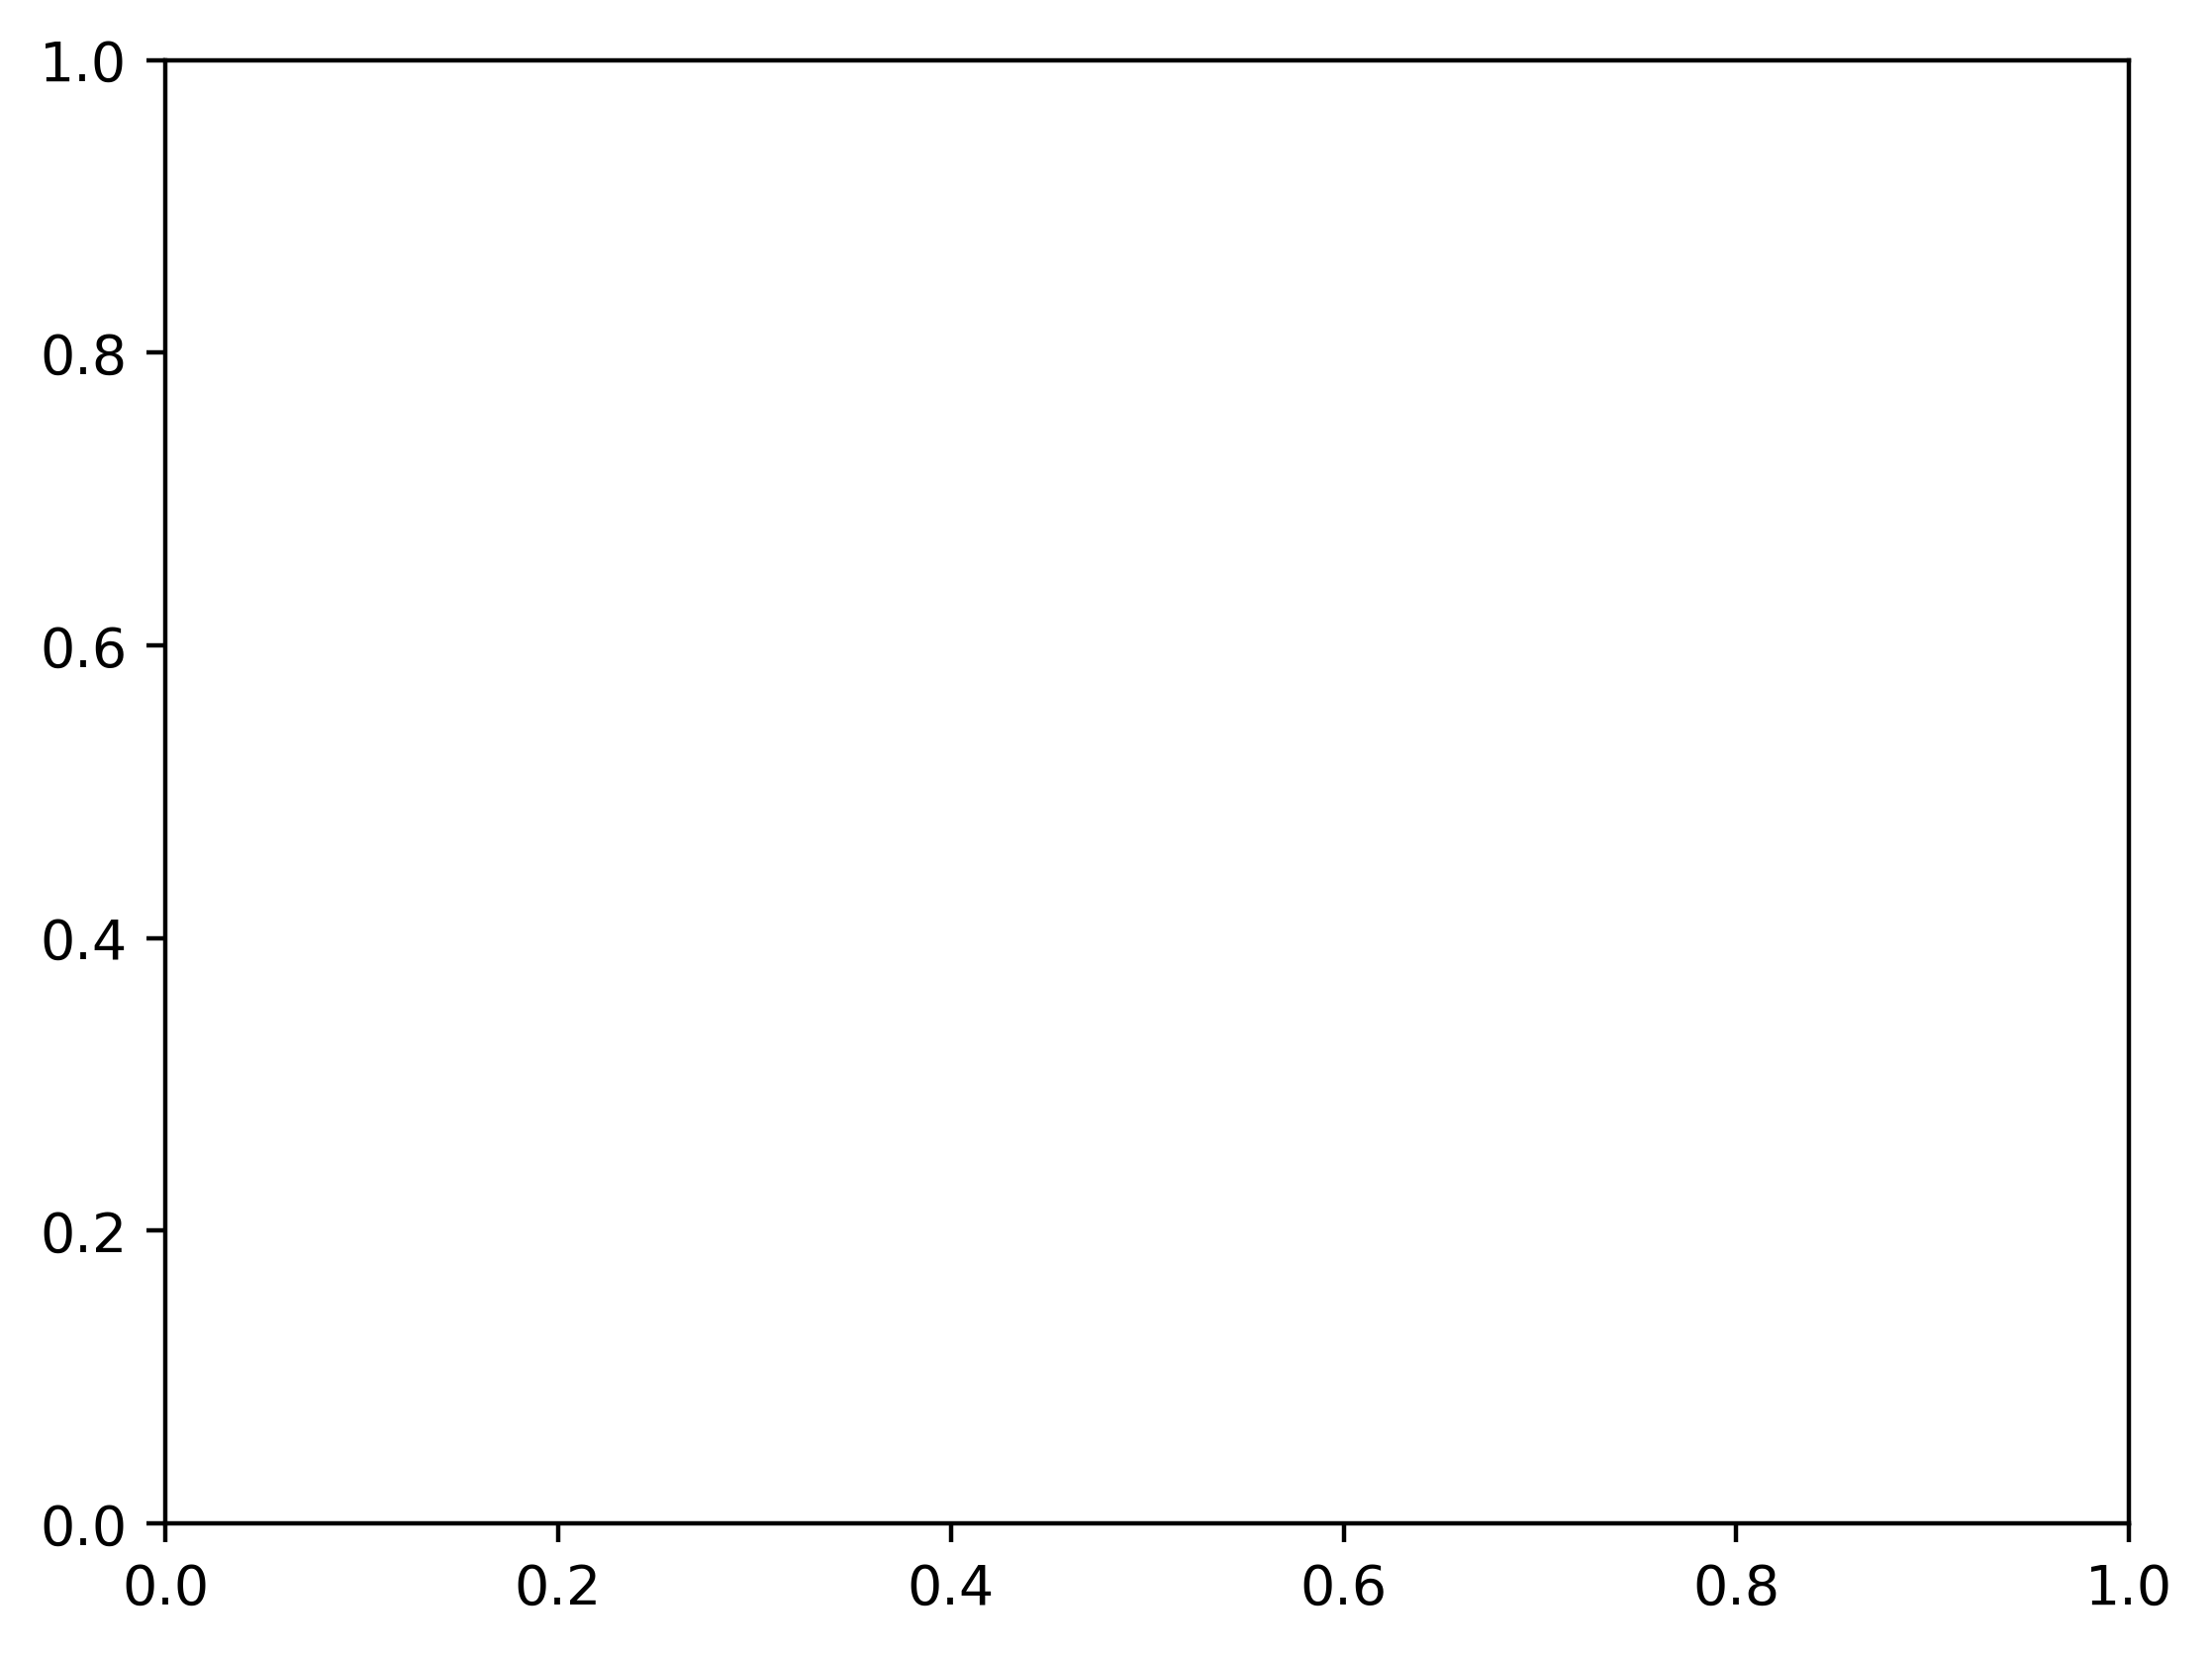

In [48]:
# n = 10, N= 20000
n = 10
N = 20000
num_servers_list = [1,2,4]

# Run M/M/c
lambda_ = 0.015
scheduler = 'fifo'
mode = 'Markov'
print_statistics = False
rho_min, rho_max = 0.7, 0.95
rhos_step = 0.01
rhos = np.arange(rho_min, rho_max, rhos_step)
mus = lambda_ / rhos

#fig, axs = plt.subplots(dpi=400)
data = generate_waitingtimes(lambda_, mus, N, num_servers_list, scheduler, mode, n)


{1: {'x': array([0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 ,
       0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91,
       0.92, 0.93, 0.94]), 'waitingtimes': [109.89409269991222, 117.50379664032839, 125.20568772526379, 132.70733850199525, 145.92770693915162, 150.84861739226739, 158.1364063746233, 168.30547625329683, 177.06726447136032, 189.56071613802445, 216.25764340002607, 225.665553798371, 261.06657850856243, 279.3714951497984, 294.8603503191654, 320.622071017004, 356.3964061496464, 402.24966909389025, 457.74249675498595, 467.3702033754138, 536.1743644966402, 574.8823047315934, 664.8499227506843, 856.7610416916257, 864.642010108421], 'confidences': [3.5114894997821886, 2.573973026944612, 5.005813577888844, 4.149597889693112, 5.5646990701648935, 5.804775049754957, 5.2799243568724705, 10.388294746832948, 7.841889223402209, 8.886341073532797, 8.580323332784248, 9.813653904304747, 22.819622578341125, 14.564785584544804, 25.6308814156627, 24.66591

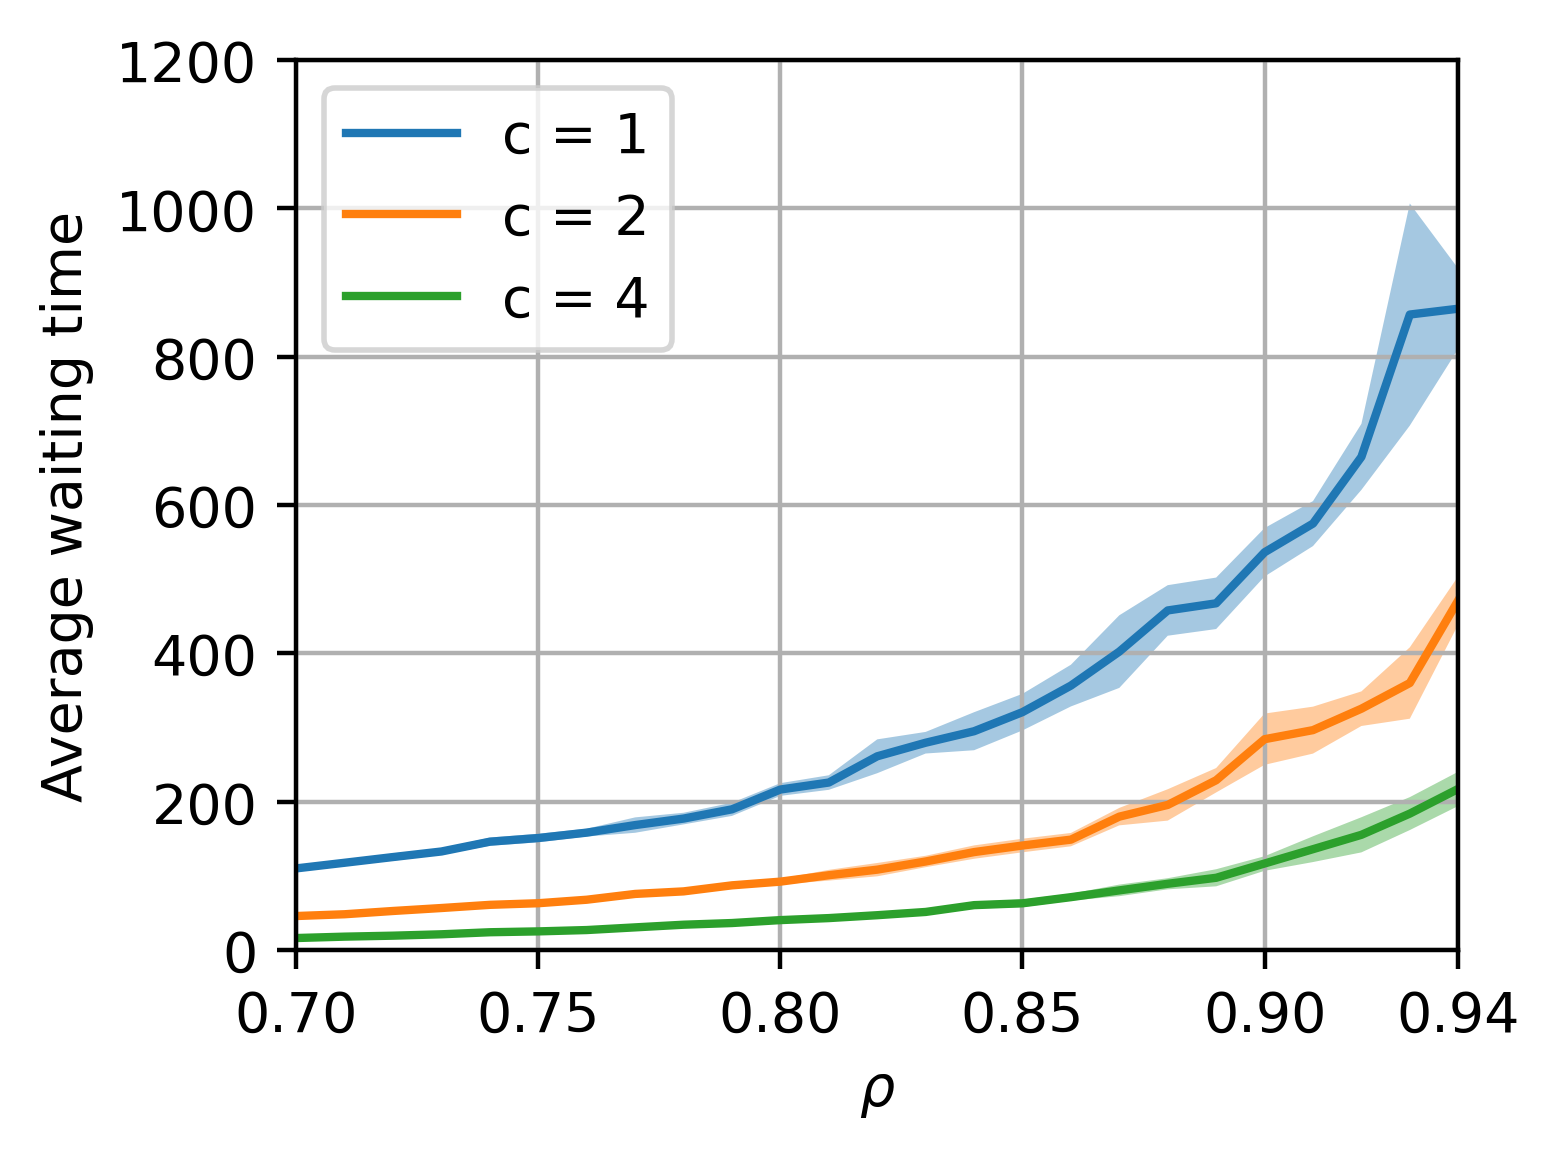

In [78]:
# Plot
print(data)

plt.figure(figsize=(4,3),dpi=400)

for num_servers, values in data.items():
    x = values['x']
    waitingtimes = values['waitingtimes']
    confidence_waitingtime = np.array(values['confidences'])

    plt.plot(x, waitingtimes, label=f'c = {num_servers}')
    plt.fill_between(x, waitingtimes - confidence_waitingtime, waitingtimes + confidence_waitingtime, alpha=0.4)

plt.xlabel('$\\rho$')
plt.ylabel("Average waiting time")

#plt.title('FIFO')
plt.xticks([rhos[0],0.75,0.8,0.85,0.9,rhos[-1]])
plt.xlim([rhos[0],rhos[-1]])
plt.ylim([0,1200])
plt.legend()
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
#plt.show()
plt.savefig('Q2_MMc_FIFO.png')

In [69]:
# n = 10, N= 20000, NOW WITH SJF
n = 10
N = 20000
num_servers_list = [1,2,4]

# Run M/M/c
lambda_ = 0.015
scheduler = 'sjf'
mode = 'Markov'
print_statistics = False
rho_min, rho_max = 0.7, 0.95
rhos_step = 0.01
rhos = np.arange(rho_min, rho_max, rhos_step)
mus = lambda_ / rhos

#fig, axs = plt.subplots(dpi=400)
data_sjf = generate_waitingtimes(lambda_, mus, N, num_servers_list, scheduler, mode, n)

{1: {'x': array([0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77, 0.78, 0.79, 0.8 ,
       0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88, 0.89, 0.9 , 0.91,
       0.92, 0.93, 0.94]), 'waitingtimes': [106.48840172355888, 115.30119657880994, 124.36978357126932, 132.7067087649877, 138.09225288199457, 156.68405766599082, 157.239131176309, 167.76601150839988, 190.55162996910798, 203.73596743429948, 206.02102282469815, 239.2879935772563, 249.11456356035882, 265.211535429889, 282.23925596523316, 326.2417324398567, 333.1015453240146, 372.2068638388123, 456.8855546074066, 471.4837409774521, 535.4628013352491, 559.2837680831246, 665.676235991115, 856.5593891100941, 928.7509134904058], 'confidences': [3.748601906043358, 4.254522785491869, 5.051776839318759, 7.691868237561787, 7.352086109089203, 8.027994317417912, 4.466423939055225, 4.59898716847141, 10.454277018309076, 17.573208298681664, 10.27190325427412, 12.380068526455844, 11.322077012134333, 11.81825368840816, 15.436744835438597, 18.88292763

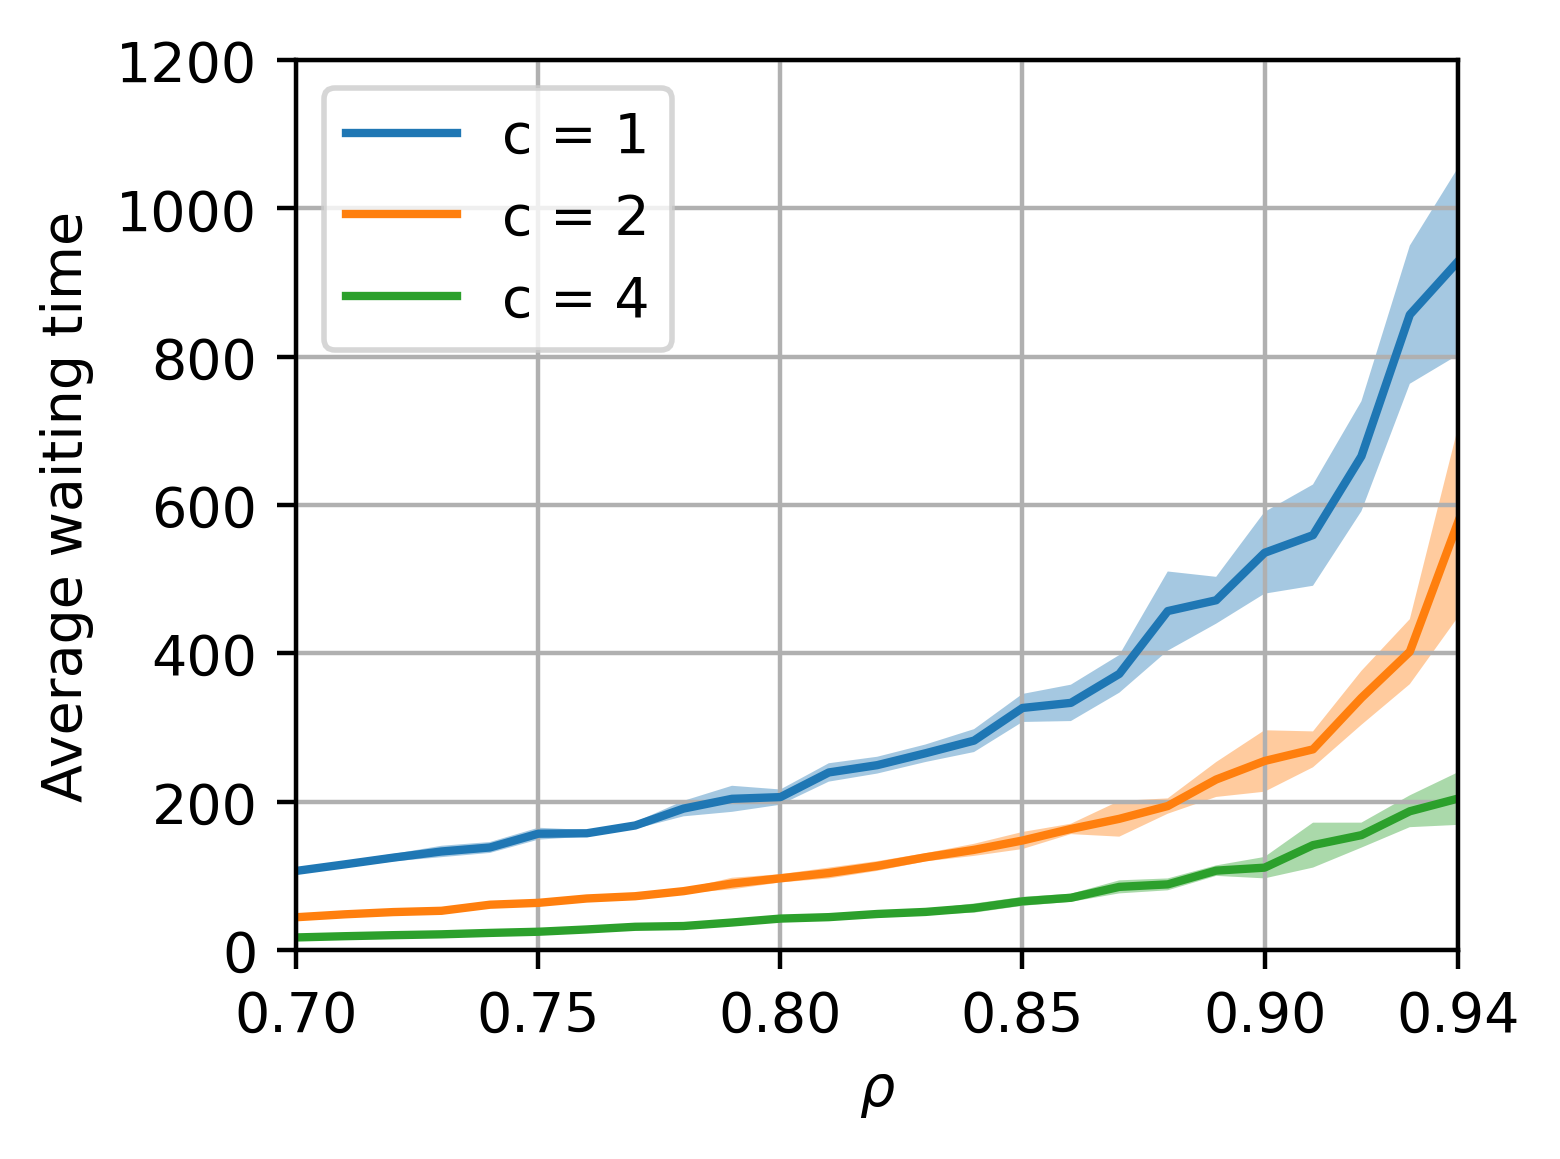

In [79]:
# Plot 2
print(data_sjf)

plt.figure(figsize=(4,3),dpi=400)

for num_servers, values in data_sjf.items():
    x = values['x']
    waitingtimes = values['waitingtimes']
    confidence_waitingtime = np.array(values['confidences'])

    plt.plot(x, waitingtimes, label=f'c = {num_servers}')
    plt.fill_between(x, waitingtimes - confidence_waitingtime, waitingtimes + confidence_waitingtime, alpha=0.4)

plt.xlabel('$\\rho$')
plt.ylabel("Average waiting time")

#plt.title('Shortest Job First')
plt.xticks([rhos[0],0.75,0.8,0.85,0.9,rhos[-1]])
plt.xlim([rhos[0],rhos[-1]])
plt.ylim([0,1200])
plt.legend()
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
plt.savefig('Q2_MMc_SJF.png')
plt.show()

## Question 3


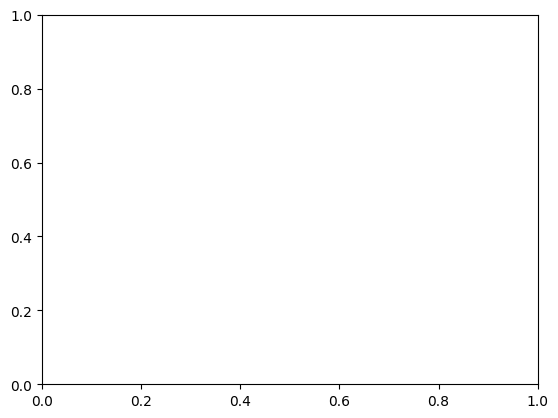

In [71]:
# Same square plot but for M/M/c with SJF
# Parameters
lambda_ = 0.015
N = 20_000
num_servers_list = [1, 2, 4]

# 'fifo' or 'sjf'
scheduler = 'fifo'

# 'Markov', 'deter' or 'long tail'
mode = 'Markov'
print_statistics = False

rho_min, rho_max = 0.1, 0.9
rhos_step = 0.1

rhos = np.arange(rho_min, rho_max + rhos_step, rhos_step)
mus = lambda_ / rhos

# Number of runs. If n = 1, confidence interval is determined by the different waiting times of different tasks
# If n > 1, confidence interval is determined by different average waiting times of those different runs
n = 10

fig, axs = plt.subplots(dpi=100)
fifo_data = generate_waitingtimes(lambda_, mus, N, num_servers_list, scheduler, mode, n)
fifo_data = {'fifo_' + str(key): value for key, value in fifo_data.items()}


scheduler = 'sjf'
sjf_data = generate_waitingtimes(lambda_, mus, N, num_servers_list, scheduler, mode, n)
sjf_data = {'sjf_' + str(key): value for key, value in sjf_data.items()}

data = {**fifo_data, **sjf_data}

#plot_waitingtimes(data, axs)

{'fifo_1': {'x': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'waitingtimes': [0.7428968116155024, 3.339927173208276, 8.61236456715439, 17.72457786418799, 33.33210870132051, 59.794799920313935, 110.64717966608427, 203.9817343296412, 538.5880843241605], 'confidences': [0.021008066614607777, 0.07178545615311739, 0.14330942966956225, 0.3688033053284837, 0.7767978429649122, 1.8864874842474808, 4.53919458562823, 6.200821342535544, 40.204055772394476]}, 'fifo_2': {'x': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 'waitingtimes': [0.06408398868017093, 0.5601143882432644, 1.9477629890210157, 5.060920767174433, 10.985085839613934, 22.64897208165055, 44.24550702296612, 95.38934623182556, 248.6249203911102], 'confidences': [0.0027578520158920788, 0.025590881755344925, 0.06892025920561269, 0.16765514012103877, 0.25973180475256913, 0.6505120226487567, 1.8133212441502498, 4.321461469861561, 27.065350781323726]}, 'fifo_4': {'x': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9]), 

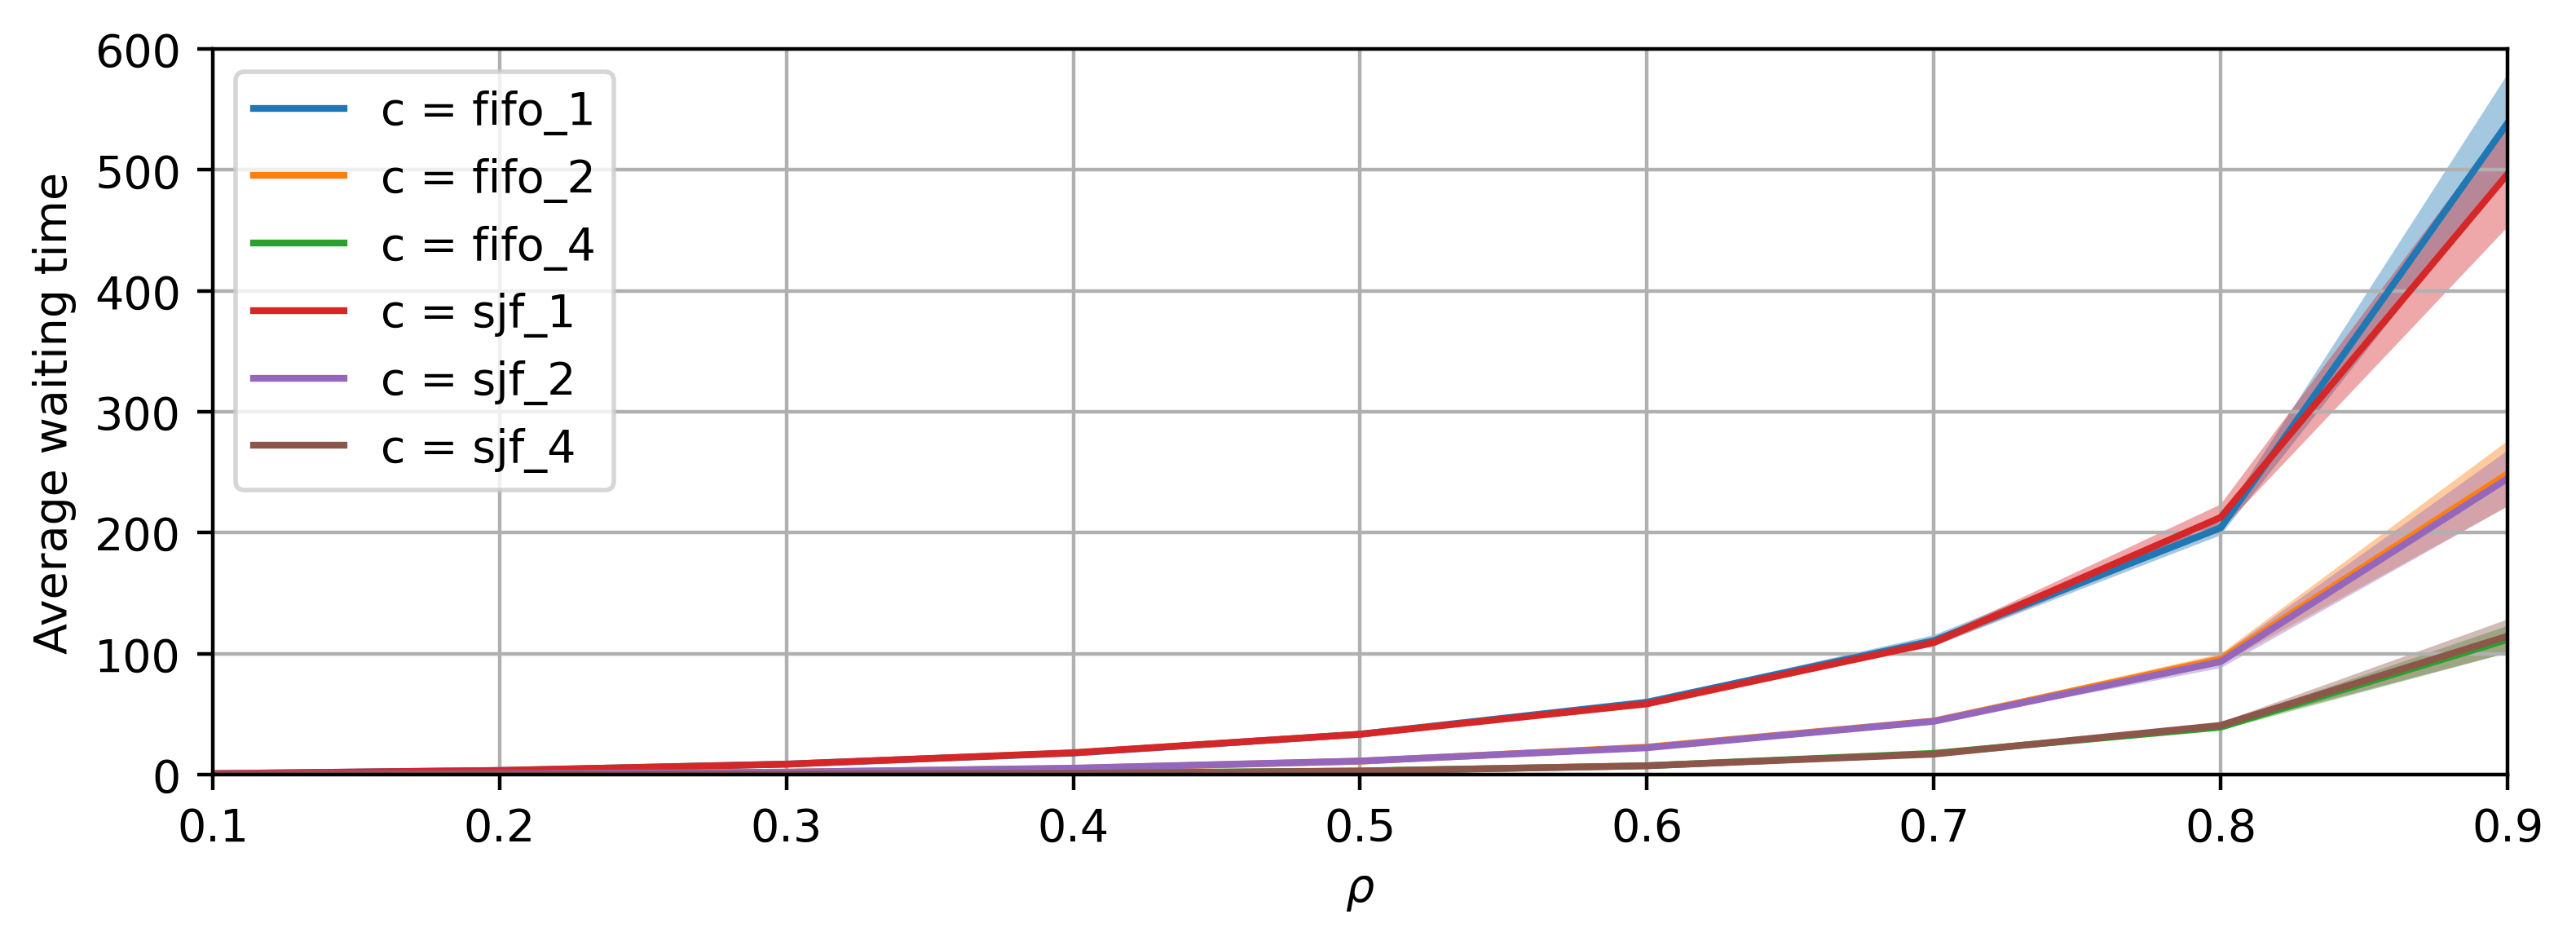

In [75]:
# Plot
print(data)

plt.figure(figsize=(8,3),dpi=400)

for num_servers, values in data.items():
    x = values['x']
    waitingtimes = values['waitingtimes']
    confidence_waitingtime = np.array(values['confidences'])

    plt.plot(x, waitingtimes, label=f'c = {num_servers}')
    plt.fill_between(x, waitingtimes - confidence_waitingtime, waitingtimes + confidence_waitingtime, alpha=0.4)

plt.xlabel('$\\rho$')
plt.ylabel("Average waiting time")

#plt.title('FIFO')
plt.xticks(rhos)
#plt.xticks([rhos[0],0.75,0.8,0.85,0.9,rhos[-1]])
plt.xlim([rhos[0],rhos[-1]])
plt.ylim([0,600])
plt.legend()
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
#plt.show()
plt.savefig('Q3.png')

## Question 4

In [95]:
Q4_markov = {1: {'x': np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
         0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
         0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
         0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
         0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
         0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
         0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
         0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
         0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
  'waitingtimes': [0.006953154993614734,
   0.02606128662019179,
   0.061977295213286876,
   0.10779230933533235,
   0.17149155097583982,
   0.2402499017042449,
   0.3631385302767631,
   0.5004171962938668,
   0.6459136319686123,
   0.7007874973339432,
   0.8534267521786938,
   1.1280333600395807,
   1.2664662559332263,
   1.5197816276598828,
   1.7199403175722743,
   1.8811394660355951,
   2.2319825284024537,
   2.784515991298262,
   3.0514396290586703,
   3.141236332314677,
   3.7173847879077226,
   4.046011794240662,
   4.713554097720158,
   5.172013403770496,
   5.652946791915218,
   6.1360030601202284,
   6.719028075798713,
   7.0156289783753145,
   8.090175047916397,
   7.88868442612635,
   9.061608247885632,
   9.857497555883532,
   10.726412094650453,
   11.4815777861818,
   13.052315122642351,
   13.095107439053116,
   14.053376503212451,
   15.11931620024505,
   16.358536572781293,
   19.125651868399544,
   16.97515663556295,
   19.522429530528917,
   19.682825626331383,
   22.68740117455486,
   24.21850153040534,
   25.259479392203104,
   25.737881657864786,
   30.24363769016924,
   30.733511926911657,
   35.34846850844329,
   35.23234470462374,
   34.29804543671504,
   42.48096174427507,
   44.890555758706995,
   42.37020786704261,
   46.15540599440059,
   53.055259878059836,
   55.79209161903457,
   53.398361966984815,
   58.41890362074616,
   66.85025033241055,
   65.77647316137046,
   68.31836916938776,
   73.67699147155611,
   77.67307117699028,
   89.8127032787473,
   89.81559028736122,
   112.6920378070373,
   95.18179209820119,
   97.01502109750845,
   114.19732851550974,
   114.55843460470632,
   113.86603341171627,
   138.10780374500152,
   144.62184644933862,
   147.86711404365363,
   159.97067515274793,
   164.4788335091223,
   195.9823957737431,
   187.7483640186809,
   245.465147009842,
   281.6760943901472,
   276.0440925540845,
   312.5043604463806,
   296.93600538485555,
   298.3863430004932,
   375.66717222165084,
   356.6148697329488,
   373.9132880287219,
   362.84388914000414,
   513.4269280511169,
   684.6516566503853,
   684.9047132022135,
   827.8256207673734,
   811.4380352229492,
   864.1842054893131,
   1064.597659825584,
   1200.6479147960943,
   1291.0712408353365],
  'confidences': [0.0024706012223339804,
   0.006863710780481017,
   0.01143455172677422,
   0.018312388629614353,
   0.026294855433124965,
   0.04165260870974618,
   0.03733540404382459,
   0.07033901746402166,
   0.06459731710450405,
   0.08114622452865507,
   0.0865557258519427,
   0.09296597815349959,
   0.1566515918616377,
   0.16552058022630953,
   0.24608004903289918,
   0.19730992079972215,
   0.2846367599780226,
   0.14703793829174325,
   0.21659918491672295,
   0.23925169054354284,
   0.30411120770989963,
   0.2560179610595782,
   0.2580033659375848,
   0.57821496930729,
   0.336912587181341,
   0.36167020670813377,
   0.9414477219750433,
   0.6389007011156255,
   0.6398889267883404,
   0.5841847539583159,
   1.1579405909982459,
   0.8232832021926483,
   1.1055204292345155,
   1.1334699259661012,
   1.2877519775256494,
   1.3186549291716294,
   1.061256671204968,
   1.2248026397309053,
   0.9743990341034867,
   2.115282576537862,
   1.299832167244044,
   1.527501703663056,
   1.479723265259053,
   2.395861189537663,
   4.026807223538711,
   3.1760090422841603,
   2.488246286792759,
   3.6579945094022475,
   2.876970805160134,
   2.485021156039924,
   2.0149208018738647,
   3.774705278214531,
   3.4138069500330874,
   6.387973391035495,
   4.80301886592032,
   7.970739257603083,
   5.835171549818953,
   11.004483157553956,
   3.8704618962944863,
   8.564593505720833,
   8.541947027218587,
   8.355036068003363,
   9.804745472772856,
   6.683729047206078,
   12.236536220703893,
   13.854520093420758,
   11.106147140496821,
   17.82037688681536,
   12.935581851904175,
   18.672068090112887,
   20.34208341849855,
   18.552424722731583,
   19.134282603558283,
   21.3453619228357,
   24.72735436492014,
   27.73143310964596,
   30.419963665281887,
   32.15999551299817,
   31.47664921425788,
   45.87523820609475,
   56.520299373661,
   57.8186673905169,
   63.65044947736658,
   103.4252951659506,
   78.1503220575696,
   68.07277336930923,
   106.30531609874815,
   97.2564106449501,
   93.1084572552757,
   66.70630865708851,
   99.90714431292017,
   99.91458638609258,
   99.224186658892,
   99.27067055958285,
   98.50916940952045,
   98.67991688639788,
   98.60708943005821,
   98.63649233105596,
   98.35157118316229],
  'n_simulations': [11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   15,
   11,
   11,
   15,
   11,
   11,
   11,
   27,
   42,
   45,
   87,
   106,
   68,
   191,
   187,
   277]},
 2: {'x': np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
         0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
         0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
         0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
         0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
         0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
         0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
         0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
         0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
  'waitingtimes': [5.3496578706968155e-06,
   0.0005869377654086996,
   0.001964863269423301,
   0.004239995106691729,
   0.006151881754976819,
   0.019208701871104447,
   0.01814413591825706,
   0.035917691487276845,
   0.05305828880328855,
   0.054673469787001605,
   0.08890479717518868,
   0.10420615150983357,
   0.13540083296504848,
   0.15198896776472878,
   0.2691131572421415,
   0.3256984883161218,
   0.27837461819026454,
   0.47381349196604705,
   0.5327245516633964,
   0.599436420605929,
   0.6730177723359764,
   0.7190156516560632,
   0.8744557504004576,
   0.8411808606248402,
   0.957834916863468,
   1.3402053135563659,
   1.3482731086363176,
   1.4425841360937488,
   1.5082457361490917,
   2.1081854900555013,
   1.9147945737881384,
   2.3227968331041633,
   2.727476080030123,
   2.9078123785341727,
   3.4057101715930744,
   3.3771431777847325,
   4.196491374265514,
   4.2237473063174225,
   3.9350706729375102,
   4.929456151642422,
   5.59502414664719,
   6.888964102436208,
   6.552160943752687,
   6.158191042132862,
   7.370126685466232,
   8.215009742665405,
   9.235607141634153,
   10.785941273511977,
   10.060214785226073,
   11.22480493234773,
   11.113988882991295,
   12.62933534997015,
   13.841625763240012,
   12.910130634766352,
   16.743263924158104,
   16.629730586117525,
   19.941034881037254,
   18.991081966492015,
   21.959351238844434,
   19.546531485813617,
   23.942612297429108,
   25.856620483896833,
   28.25564805494888,
   29.01104856800328,
   28.75886784999904,
   33.28763276262558,
   36.1296618991932,
   37.94321467443654,
   47.730925051545974,
   40.51828038377402,
   50.878303868443865,
   47.0605668335528,
   61.5031669157101,
   56.53196463142881,
   75.38199288591869,
   70.6759429384558,
   76.71796963688327,
   99.08588110200103,
   74.12010805395477,
   91.04324935107799,
   120.63491180792674,
   103.21999238882853,
   110.39044558384586,
   137.36657187902898,
   166.10953625160556,
   119.31291455378518,
   156.07387354588911,
   197.6240426661188,
   182.23203437456183,
   231.01018645818806,
   285.4874608255854,
   317.59411679754334,
   293.04244258134503,
   242.61861973182042,
   375.81701820003565,
   351.1851550070564,
   556.8639946851223,
   462.6185582154756,
   675.340241705863],
  'confidences': [1.1365064823028473e-05,
   0.00047260467079453575,
   0.0012522722652618403,
   0.0021090338341457266,
   0.001705677439473599,
   0.005302572789336123,
   0.006965053128996803,
   0.010334421625008947,
   0.023655530507865806,
   0.015144825579837878,
   0.016957703406451825,
   0.02022223098467681,
   0.015615805157808674,
   0.029034693234829958,
   0.055434618556484856,
   0.09265561985859042,
   0.041878114871805434,
   0.0854146752867217,
   0.11790609634146931,
   0.08019108633573742,
   0.1315619683056648,
   0.08823161795473378,
   0.13298638476324565,
   0.13796311278721968,
   0.07395617076654978,
   0.28811333954708646,
   0.13538616334495854,
   0.19793140983698285,
   0.17571827722015793,
   0.3754401953111911,
   0.23295278186464274,
   0.1492466393655936,
   0.30173893262060963,
   0.3722500266490224,
   0.47163254216939815,
   0.47587208751232324,
   0.516223652234449,
   0.4759746173605721,
   0.7603892882540748,
   0.5404250476786554,
   0.7747737707523652,
   1.213879294710009,
   0.8790534997445925,
   0.6377882653830708,
   1.0768936688679682,
   0.9745298592841601,
   0.6644751408832119,
   0.7852576243036268,
   1.795264312719368,
   0.5113450252748595,
   1.5512980475201625,
   1.9733822664976577,
   1.6811992385445547,
   2.0940271623825124,
   2.2255364220084926,
   1.8825768670098668,
   2.612279115538754,
   2.5399119845772464,
   2.2860475829780817,
   3.2075040250581903,
   2.9430639492718274,
   4.345141898920496,
   4.1093301214849545,
   6.390715628212982,
   3.341364426130085,
   6.101612054488534,
   7.6540336021676705,
   4.597663258679821,
   10.511139255198186,
   4.779867637067425,
   11.784798699515173,
   8.415087436014966,
   9.428047540114976,
   10.71131163842219,
   31.622756480328768,
   9.253894438713347,
   15.382560211546277,
   29.756451804498663,
   7.431276287779545,
   11.317439803802749,
   30.92922455055922,
   21.41346866645543,
   25.093880601936355,
   31.69861322377151,
   56.727616595265744,
   31.822918599110018,
   26.257159604964265,
   69.05137625798434,
   54.04024019721806,
   74.18471685583869,
   101.50833309182575,
   88.57971497055613,
   77.40238830126319,
   46.18903558351648,
   101.18539001334291,
   98.52334475263507,
   105.75137911601679,
   103.22062926335965,
   100.27966954131207],
  'n_simulations': [11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   13,
   11,
   11,
   11,
   28,
   11,
   12,
   19,
   47]},
 4: {'x': np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
         0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
         0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
         0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
         0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
         0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
         0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
         0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
         0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
  'waitingtimes': [0.0,
   0.0,
   0.0,
   0.0,
   8.503645899294167e-05,
   0.0,
   7.850350607420544e-05,
   0.00014222495665345295,
   0.0010857502185659044,
   0.0004944871253528618,
   0.0027716570503948062,
   0.0026284338170093676,
   0.008345612841540785,
   0.00727717111562759,
   0.009333428844809739,
   0.013235020007948779,
   0.018977967232908545,
   0.01864918057927718,
   0.030642133232435507,
   0.05135697348671989,
   0.045388920673967915,
   0.05099962439862926,
   0.07330416695100025,
   0.12037122762610325,
   0.1058665050772718,
   0.13316074412766327,
   0.13994884199861282,
   0.26090500520848064,
   0.2923085945647777,
   0.30024023262635424,
   0.3370793317596028,
   0.3384983659184773,
   0.3895815472294815,
   0.5411990784223977,
   0.612785660004244,
   0.7241336627982183,
   0.626308549306406,
   0.6914194587453335,
   0.8721616432646374,
   0.7916792788175954,
   1.110369149872736,
   1.2015446706641368,
   1.4476010900135867,
   1.3874350936223734,
   1.8309664833832349,
   1.7699049085696346,
   2.2632372094807143,
   2.423356316707826,
   2.5340804961943273,
   3.651466795941479,
   3.1967646125675233,
   3.5905293786588484,
   3.7721991664574137,
   3.9704824931237925,
   4.286407438610055,
   4.146403397292139,
   5.379647181596856,
   6.765321294944102,
   7.246071292598705,
   6.01661815788527,
   6.553110917163843,
   8.844663426591262,
   8.835955473450332,
   10.660593629020703,
   10.07744803376704,
   10.773003356786829,
   9.737424541000442,
   12.75145696546375,
   14.949022285105247,
   16.105546558696187,
   21.62330649459929,
   17.992658352772533,
   19.24598497764996,
   23.066859465106408,
   26.255636332389166,
   26.7556497888002,
   36.881854324485566,
   31.020285703551455,
   48.033789754032526,
   35.30387792414423,
   40.73447942032996,
   37.55451583206311,
   46.304531426619405,
   60.81774309915789,
   41.90804230070539,
   60.44092123743442,
   105.67637111499566,
   96.23214028935571,
   81.84542664567981,
   119.9906421676314,
   143.09064827536892,
   102.65479802178048,
   155.57580863908535,
   187.47538008534883,
   193.0313113122287,
   160.55486149278465,
   295.08662049718487,
   315.5543583148788,
   280.3093317907674],
  'confidences': [0.0,
   0.0,
   0.0,
   0.0,
   0.00018065545351402093,
   0.0,
   0.00016677654102992978,
   0.0003021493880333631,
   0.0013255685591603314,
   0.000645411115333032,
   0.002606215362572235,
   0.0019040866549112976,
   0.008251199619767353,
   0.004909416543292878,
   0.0046563467761237985,
   0.00856138807557983,
   0.008985438568477335,
   0.006991730127093488,
   0.012102449706064642,
   0.027089374812912608,
   0.01700714600025923,
   0.021245706675689677,
   0.02925413375450552,
   0.027056903911037454,
   0.02297725000366624,
   0.037991939340274145,
   0.037602417280791285,
   0.09450428995476552,
   0.1281176419418374,
   0.10303853332968992,
   0.14997502497877324,
   0.09195084210732686,
   0.11269573224196713,
   0.24990661827050709,
   0.18634445070579087,
   0.19832172932338898,
   0.15370529580375988,
   0.1567018074947475,
   0.17152912904350626,
   0.1534448523625068,
   0.24057709685965636,
   0.23610441173971322,
   0.2158039597566615,
   0.3293013599093824,
   0.54929250561233,
   0.28397390134403616,
   0.45714029685340274,
   0.5866706165008692,
   0.35251297625318556,
   0.9126143171407892,
   0.6183594715282997,
   0.7333642687157977,
   1.0364712080483984,
   0.7033307809859792,
   0.8775888004825528,
   0.8748028116279318,
   0.8267751349350901,
   1.489402349988426,
   2.0659862414712302,
   1.0484758336499833,
   1.6421140525121873,
   1.687456554537093,
   1.9392140064736405,
   2.17893303072869,
   2.181898573403136,
   1.5445988182363308,
   0.9638414099396624,
   1.7559029022316488,
   3.0864061626010377,
   3.4569046538009793,
   6.102483149959835,
   3.5259075155885413,
   2.4794106758652084,
   4.453218423544336,
   6.379447456846814,
   9.414393577899537,
   11.674682167058128,
   9.177384964192305,
   23.346472344276602,
   9.673011475506529,
   13.962556095441645,
   10.358655002308824,
   13.39220540866362,
   34.2252159364361,
   10.073148548729954,
   12.517548928829134,
   58.393702027780634,
   19.170124486401058,
   20.76147275201168,
   46.08155245331702,
   74.03442843214445,
   27.86881580756119,
   59.2417012666665,
   74.63444777995677,
   69.04249438682558,
   54.329733514351375,
   103.47355080594176,
   102.39653602306285,
   87.33541718701463],
  'n_simulations': [11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   19,
   22,
   11]}}

In [96]:
Q4_deter = {1: {'x': np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
         0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
         0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
         0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
         0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
         0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
         0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
         0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
         0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
  'waitingtimes': [0.002865025678040897,
   0.014685212425380739,
   0.03230699693746496,
   0.058209815330892416,
   0.08886895013731802,
   0.12679955405215337,
   0.17661964787163578,
   0.2284415900423267,
   0.31534272892313875,
   0.3721615649036876,
   0.4559765261177835,
   0.5429998095903725,
   0.6819809811882812,
   0.7748788320573966,
   0.8786002736639584,
   0.9856533355363076,
   1.1325756966184362,
   1.356733580216904,
   1.5385790905087575,
   1.6388375222966445,
   1.9037626826032912,
   2.200864699170582,
   2.2197611769465806,
   2.440906709426454,
   2.9877816576142795,
   2.9838921850162694,
   3.473926625486442,
   3.6574284164986555,
   3.842738920232847,
   4.321877362968234,
   4.6936861068918265,
   4.686595789973591,
   5.64965886058943,
   5.659340540019175,
   6.236455486302407,
   6.843670075536445,
   6.836747848043612,
   7.7908635459568165,
   8.290237245783413,
   8.960114372648798,
   9.753052440080314,
   10.244425015881697,
   10.457568617305071,
   11.300263745231963,
   12.076975927091416,
   11.93672495276498,
   13.937404568017094,
   14.7754682671198,
   15.146938607538187,
   17.07424416129871,
   16.534325139413028,
   18.37321252696428,
   19.506603259004144,
   20.304809429435483,
   21.75120433689044,
   24.453318095362253,
   25.62265276875415,
   25.41377036655945,
   29.30115857675383,
   28.60460664838162,
   32.32521844749422,
   32.93489199392518,
   36.3970110726135,
   37.521351934232165,
   38.20853554744997,
   41.066094417469856,
   44.962051679804325,
   46.84246207108927,
   52.984608631688616,
   47.624738340142514,
   52.983497692406075,
   58.016460898498124,
   66.22265900876313,
   67.27756196136788,
   72.09526983875934,
   80.5340449341886,
   98.57930594435696,
   90.94585447874523,
   98.33916242429721,
   101.57491606216719,
   115.23008238751873,
   110.42359688370034,
   147.40895571874407,
   166.93947720317422,
   139.48155795014983,
   182.30307213148066,
   163.95425381231854,
   196.6269094411714,
   209.1863405107733,
   235.28441093047124,
   273.7091066574052,
   303.54545110601316,
   398.86413475882813,
   482.82394375445483,
   491.9952892254,
   488.6227207883372,
   566.2554273662371,
   845.6087775089549,
   941.1171021781189],
  'confidences': [0.000416929056213118,
   0.0028407227713405456,
   0.005723848162936169,
   0.006921291988330804,
   0.009045529272971241,
   0.016600406477426343,
   0.016833556001609757,
   0.02019314624410757,
   0.0311791595756627,
   0.03455926475976105,
   0.026338949080180384,
   0.04237800842340097,
   0.04439685238960708,
   0.06620342837094152,
   0.04295919053831169,
   0.0581696549317851,
   0.06963761846185151,
   0.08674108715741088,
   0.09895436386208183,
   0.08482714466831924,
   0.1667270900547365,
   0.21140275207319176,
   0.13768041332686026,
   0.17180878118171553,
   0.25602760895056753,
   0.19426587469736137,
   0.23087581438497506,
   0.1993405593897651,
   0.29466825257467466,
   0.31689473305350363,
   0.40786920599968296,
   0.3647184194812303,
   0.29775234757255553,
   0.28935387793190015,
   0.3596872527177301,
   0.42143381053396234,
   0.5081375466476501,
   0.49103802274671754,
   0.614806169205214,
   0.4852783238387381,
   0.47987338668820567,
   0.37350343163715155,
   0.7223693409630807,
   0.9339418914021689,
   0.8710004595039516,
   0.7753607060404195,
   0.8352640123794197,
   1.1486970928949085,
   0.725182450646466,
   0.8224705154693017,
   0.9378312580174304,
   0.9333655335806039,
   1.1950747987978354,
   1.355259213373195,
   1.5961609916919346,
   2.343330212916226,
   1.808858791387833,
   1.6793617929237044,
   2.887066169383117,
   1.8314763009958857,
   2.656782627653944,
   2.7715795574905275,
   3.4791373506743835,
   2.697276154425222,
   3.338201965802691,
   3.1105394217203948,
   3.752865854674959,
   5.328519707276909,
   3.9712274690776077,
   2.4681345631031864,
   6.072857591409165,
   6.188424569188808,
   8.70522917858617,
   9.446294178034595,
   8.915864763854715,
   9.123185462587417,
   10.101768856924341,
   14.759618468210384,
   15.510585500377097,
   13.08011068157823,
   11.307929660019889,
   13.296483301642112,
   25.996744370804326,
   61.26337810960428,
   18.640149593764963,
   42.11235466215167,
   19.751983796111077,
   34.934986832357964,
   69.06585675394389,
   47.63120546989524,
   66.64835600344779,
   51.7657531175175,
   62.576756674974405,
   102.26240055250733,
   103.38261800319044,
   104.2458993964203,
   100.78917648196702,
   98.38924136135613,
   98.37824289833095],
  'n_simulations': [11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   17,
   13,
   18,
   28,
   132,
   156]},
 2: {'x': np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
         0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
         0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
         0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
         0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
         0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
         0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
         0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
         0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
  'waitingtimes': [5.0635134801930034e-05,
   0.00037795347933239435,
   0.001086116061203029,
   0.0017971045786196868,
   0.0053895077821305305,
   0.008041936283181351,
   0.016661759969559285,
   0.01859210633915705,
   0.03150547263351788,
   0.04566511541422858,
   0.0694881605037132,
   0.06921281123701888,
   0.07778508763125361,
   0.09830227346582027,
   0.13992790250811982,
   0.15697650799211804,
   0.18300425523504552,
   0.2169152324450584,
   0.3097321990040749,
   0.3344627126244852,
   0.41263565330421254,
   0.4281289089437546,
   0.48018506297981,
   0.5732973083612246,
   0.6948716124842749,
   0.6597307835026026,
   0.7866538415242065,
   0.8901244493525056,
   0.9843871685840611,
   1.115258340011607,
   1.1997992188589222,
   1.380210450508176,
   1.4063349125684506,
   1.5430504620937844,
   1.7558285002364722,
   1.9482168267230997,
   2.18950927537199,
   2.3414359702550556,
   2.5465443917459614,
   2.7803716226393003,
   2.9693054291827155,
   3.353390051410613,
   3.4153686307443376,
   3.913032652911095,
   3.9857181731203415,
   4.40302765540522,
   4.619033226711337,
   5.201315234887989,
   5.378180801670012,
   5.865760593774479,
   6.090428069659557,
   6.62470072339492,
   6.86077724673808,
   7.840809423513019,
   8.004373296379582,
   9.393874840969419,
   9.492403284309217,
   9.780902864008997,
   10.939238391880748,
   11.916807070874677,
   12.53922468458352,
   13.231493015300039,
   13.62390221563602,
   14.528350277221422,
   14.787784863846817,
   18.38047953430296,
   19.50616150001235,
   19.368054401554275,
   21.74667358431823,
   22.147982092515505,
   26.111623633719912,
   23.600541982958045,
   26.882215765487306,
   29.7746271906658,
   28.371359445109455,
   33.27048764132283,
   35.04868469633158,
   34.6057599025893,
   47.075050292212545,
   50.75867777475735,
   54.47013244660901,
   52.3431525706141,
   73.51737485158544,
   65.06001758488401,
   79.87314582963997,
   75.83108301413243,
   87.1698426997536,
   100.11138385174873,
   127.38054061050435,
   110.34396539740109,
   134.17721153196223,
   158.70732567315645,
   158.88221264577084,
   173.77730115401778,
   232.5189320215534,
   213.13889043540314,
   270.0830478559648,
   341.481911111249,
   518.064529540359],
  'confidences': [0.00010757166219898136,
   0.000301807403610839,
   0.0006253522823566509,
   0.0008884087922610769,
   0.001653931150443836,
   0.0018686591605345864,
   0.005457724762140235,
   0.006253577535968667,
   0.008248438150730692,
   0.009325972203710455,
   0.012562377412712914,
   0.011254775408674903,
   0.013430970765169862,
   0.018184397719202685,
   0.030206511834839845,
   0.016785096422809502,
   0.021614518224366035,
   0.01895167787040725,
   0.03139652811298549,
   0.02827771248784065,
   0.05172875192409653,
   0.07102433505050436,
   0.03329559276676301,
   0.06669766758560663,
   0.11277544776811367,
   0.0700989920787863,
   0.10551039308390442,
   0.07524340404655962,
   0.09614301809379776,
   0.11769461224149308,
   0.11793997337935495,
   0.14044756706799352,
   0.10305161068099773,
   0.14996594791367543,
   0.1429829887166205,
   0.30216532560081755,
   0.17565075391783955,
   0.21550072976372633,
   0.18390313596670332,
   0.3278894759647204,
   0.2372997866818108,
   0.22338104566449818,
   0.38637563702827243,
   0.32360265694070933,
   0.3530264263663822,
   0.296774458941437,
   0.5228511037818707,
   0.5154856335354756,
   0.3117791161688212,
   0.5160514907084948,
   0.6241799552745135,
   0.7177781190034264,
   0.6096303911320743,
   0.7402729880002022,
   0.8493252982488654,
   1.1375255006028973,
   0.9699974862445334,
   0.6059148656823503,
   1.3153572821736716,
   1.499746558641237,
   1.1883713914349672,
   1.3653113146243052,
   1.0578671987555817,
   1.3445999788634635,
   1.6678159880339605,
   2.1962562672836867,
   2.2280715293422078,
   2.5425118054761873,
   2.5657138158955184,
   4.732069084159778,
   3.341762188628361,
   2.5824024745610243,
   2.384288871805598,
   3.2102835313024047,
   3.1436764634581125,
   4.323075920426112,
   6.426785523381823,
   4.796674376964302,
   14.312647389972547,
   11.9922091736863,
   12.740031660955312,
   8.372319052979286,
   14.198372056085281,
   14.020339784986186,
   17.417461435508088,
   6.36210964567857,
   20.036254137407397,
   30.959490782966288,
   27.459975260340983,
   30.0646485506937,
   36.19640329582642,
   56.61714442227957,
   34.83695965965345,
   42.32934835553421,
   78.61586711386029,
   60.870497202596034,
   75.22028567223971,
   101.97082193608331,
   102.63871774160246],
  'n_simulations': [11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   16,
   27]},
 4: {'x': np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
         0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
         0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
         0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
         0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
         0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
         0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
         0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
         0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
  'waitingtimes': [0.0,
   0.0,
   0.0,
   9.052131619021318e-06,
   0.0,
   0.00012757500475248145,
   0.00010646030111944459,
   0.0004684871353513451,
   0.0009676354243125514,
   0.0007495230451818328,
   0.0025473362906944783,
   0.0026927125252090758,
   0.006053509281485172,
   0.006475699791165219,
   0.005506680158827666,
   0.004898593616235646,
   0.016953687464429983,
   0.020313625876726023,
   0.0200867919264511,
   0.039945445908089766,
   0.029576672423366087,
   0.04241923215431323,
   0.05152736259991815,
   0.049143195565188265,
   0.07556460087905777,
   0.08336233855179677,
   0.10272881161175702,
   0.11309266533602359,
   0.12910768679209028,
   0.16557489762290006,
   0.21004837817436553,
   0.25774373213456275,
   0.2711123231209238,
   0.3092569884076439,
   0.3531047364811354,
   0.333408533661754,
   0.4089871473785325,
   0.48109983618879143,
   0.5534082772052632,
   0.5989221306114237,
   0.6911016079334238,
   0.7769445117460527,
   0.7883607355617176,
   0.896363390243674,
   0.9421298438998774,
   1.3090814519634455,
   1.2857984523102577,
   1.3936643194852578,
   1.4665126239241402,
   1.591129118562931,
   1.8042587422406506,
   2.2275220892368055,
   2.330267435079941,
   2.213980554189171,
   2.4861564306189154,
   3.034122639724178,
   3.1515336803480665,
   3.7004902496203487,
   3.6557512487108483,
   3.8437411475489522,
   4.3443872194155775,
   4.274633651098896,
   5.167325058332522,
   5.263699488424464,
   5.796558533858336,
   6.452759949424544,
   6.483481624642815,
   7.154395931888271,
   8.289942242472677,
   8.653556180381338,
   8.57879693599351,
   9.565269166485736,
   10.300265567988232,
   12.702789506572522,
   12.683203749445227,
   14.89488008964224,
   15.268340556135422,
   15.25889642722435,
   18.68972021249343,
   18.381282528793108,
   22.51125250498429,
   25.56935693306475,
   25.19526609951278,
   37.97169798994245,
   34.22658145210902,
   35.654609094053725,
   42.26063591359149,
   44.44724087363848,
   56.974526552244065,
   59.18157709041055,
   76.68658559200804,
   61.623594707946886,
   90.72229949228178,
   106.1094814953216,
   77.33196979671482,
   129.87299974312643,
   159.41017478619233,
   159.48653811613056,
   207.99197650527074],
  'confidences': [0.0,
   0.0,
   0.0,
   1.923077421460649e-05,
   0.0,
   0.0002710263410959516,
   0.0002261692714835276,
   0.0005617473985729869,
   0.0013026337758589863,
   0.0006998653644059031,
   0.0011659397443454444,
   0.0016427170803612428,
   0.004177278527204812,
   0.0034589835283972774,
   0.004014011004035479,
   0.003541080724483623,
   0.005116200095494416,
   0.007266486505499373,
   0.00671333160886734,
   0.019576545707556313,
   0.013251296607372499,
   0.016160701281486015,
   0.009960955362750303,
   0.010806498378807308,
   0.01599596642000302,
   0.014312495600337942,
   0.0321300833450753,
   0.024025687536105216,
   0.015612576045367,
   0.04463656976554305,
   0.03326124901630481,
   0.05300203639135075,
   0.04890042735635463,
   0.04244792127984199,
   0.05176579435623315,
   0.04148215682988774,
   0.06650175269708661,
   0.11266322943036718,
   0.10435888159972086,
   0.15076856135759967,
   0.13166166291106016,
   0.10476153990690028,
   0.11286612057993174,
   0.12194326086699787,
   0.15496753542245653,
   0.19290819737687168,
   0.23601660617810083,
   0.18885632646325798,
   0.1611113642837373,
   0.24090535171546054,
   0.20151438727209553,
   0.33863230188004495,
   0.4129277034213875,
   0.289615009488657,
   0.3008058846760732,
   0.42567630355708364,
   0.42588342219334796,
   0.4650590618043841,
   0.379759217990796,
   0.39187020869100075,
   0.7169391915381323,
   0.4498156796279154,
   0.6374680407528801,
   1.004304772835166,
   0.5241407246957769,
   0.6540102653364965,
   0.7392874343957142,
   0.8410911676182965,
   1.4484518139566627,
   1.066171187953338,
   0.5942952235079891,
   1.56163414511085,
   1.105457929157258,
   2.6907733712156197,
   1.3593494397811756,
   2.4973979523610272,
   1.8179458304730964,
   2.2040754404706724,
   3.223906657841965,
   2.654387479065796,
   3.90530055834144,
   6.021270913461823,
   3.538935554392175,
   10.985478159137736,
   8.113102394940068,
   13.339139959835626,
   9.266690978247533,
   11.158967456930842,
   17.52083830624398,
   12.72073474109713,
   16.81360509699087,
   13.109712129242403,
   25.511709874019196,
   38.61317561842545,
   9.735049218473879,
   45.08664754801873,
   69.87745997082338,
   47.7663518016743,
   54.28949723509599],
  'n_simulations': [11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11]}}

In [97]:
Q4_tail = {1: {'x': np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
         0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
         0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
         0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
         0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
         0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
         0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
         0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
         0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
  'waitingtimes': [0.01354152780629201,
   0.06016883221383804,
   0.1512281349696125,
   0.2327794555817156,
   0.3865672742535691,
   0.6377034106531446,
   0.8195372209806404,
   1.2646687331606843,
   1.5038740551650884,
   1.8086880687863618,
   2.1637585392537937,
   2.6658047276238843,
   3.2532846716853303,
   3.6700268913370078,
   5.006874626455003,
   5.224376875714071,
   5.818195102066408,
   6.697356301414306,
   7.234034210913345,
   9.85902429810816,
   9.265022659880636,
   10.582424051433332,
   11.761216181932618,
   13.461545229535966,
   15.510209979381834,
   16.75939807710384,
   17.487072281567777,
   17.85811296983545,
   22.92542984245357,
   21.582035303140994,
   24.341685248541342,
   27.676132980181805,
   31.33551543092533,
   32.41970137612045,
   36.27661394689266,
   38.29094013683703,
   41.384124786176045,
   44.840030082057645,
   53.25146796870606,
   53.594766146325355,
   56.00717503958264,
   59.981357025112196,
   71.39457666703943,
   70.1227748433825,
   74.62155768223627,
   83.95017833749388,
   97.43909713010261,
   113.07396780817879,
   113.71403320640157,
   127.42764984490067,
   139.98634086325973,
   153.07042087489836,
   147.51509389865416,
   160.7567564036056,
   203.37785507350264,
   240.8626573276024,
   234.80314591968545,
   246.0313476357781,
   285.3253987695757,
   313.9276397260479,
   267.51711914327024,
   346.0172817439711,
   445.2650106609541,
   380.60139316971487,
   580.7083566564329,
   549.7824749436298,
   866.9787836728545,
   780.2464326974946,
   1071.2576471285888,
   1333.438615319433,
   1067.9289486223126,
   1535.727881916364,
   1522.889664555,
   2188.3742918552734,
   2219.5659661538525,
   2162.477935758808,
   2981.3965976619456,
   3328.261610406965,
   3826.8396028210936,
   4050.2731528578533,
   4283.169798268415,
   4929.71437264339,
   5413.413468300666,
   5786.159573025254,
   5986.775074257634,
   6618.223346072829,
   7069.062770563812,
   7557.334825849462,
   7684.592439202217,
   8197.925668760676,
   8806.407074101176,
   9078.595740988341,
   9637.287169330228,
   10002.794593427618,
   10604.94832580026,
   11092.775709374771,
   11645.013669060112,
   11766.614947440872,
   11858.030517205767],
  'confidences': [0.0035991882312176936,
   0.01397673109829138,
   0.020512679402008537,
   0.025936766189019425,
   0.03761601543153778,
   0.12451290802281133,
   0.09413462121993424,
   0.18452000273361968,
   0.21950075379637313,
   0.16867264505265103,
   0.2181311761412233,
   0.1882898806926264,
   0.4625555802316561,
   0.42201013155218586,
   0.5698715579238275,
   0.574374582206628,
   0.7988081488760835,
   1.0862473086322584,
   0.7341346083927867,
   1.0662987864688889,
   1.1729197238090672,
   0.9731609496504842,
   1.1192630009462645,
   1.5165639385794418,
   2.088288040612239,
   1.7474452253139754,
   1.3092456745961591,
   2.215743116323518,
   2.6366973658200132,
   2.461260071135433,
   2.707686780526401,
   2.800988775680592,
   3.5202026632300223,
   4.1138215478964595,
   4.247735574529529,
   3.718185602845115,
   6.176921293956421,
   4.792027517477397,
   10.656178703621315,
   7.524625594842746,
   7.06159967505815,
   8.147831485446037,
   10.76983409912073,
   9.989974098010467,
   8.369369200872498,
   8.04323046067357,
   18.911755146504895,
   15.768099643427092,
   13.12279424299626,
   22.97614622143922,
   27.616564813416876,
   18.63099010415821,
   24.710624806650404,
   25.509315669993654,
   60.255124098259635,
   44.70616739507464,
   56.187942120551995,
   74.70541569273607,
   51.66230646277221,
   86.73761785126656,
   44.811994596172575,
   74.82680676057302,
   151.06304901246946,
   131.35847308455388,
   146.89272323603188,
   201.77482649926986,
   317.7462545543089,
   329.2879924904855,
   304.82152008610115,
   323.6797577006134,
   310.87301982394837,
   308.1670309046323,
   301.00220777779316,
   296.60898682271954,
   297.2685911418818,
   300.9319402192379,
   296.9169527052521,
   296.7748182979246,
   294.79641136426955,
   296.58089689016253,
   296.1998119276403,
   295.8523543422871,
   295.10514576416193,
   295.95241789580047,
   294.62324037435945,
   295.8402762398224,
   294.85076008782386,
   295.0125940554749,
   295.38707806741814,
   295.3126413986025,
   294.56347989008776,
   295.4684770927691,
   295.95149930361464,
   295.5439969669259,
   295.59264489084757,
   294.58562428034077,
   295.40290596803,
   294.75077157885437,
   295.0758731850477],
  'n_simulations': [11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   14,
   11,
   23,
   13,
   16,
   25,
   21,
   52,
   76,
   40,
   97,
   103,
   109,
   135,
   128,
   145,
   151,
   163,
   177,
   167,
   180,
   206,
   154,
   183,
   214,
   200,
   161,
   211,
   200,
   202,
   234,
   218,
   216]},
 2: {'x': np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
         0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
         0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
         0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
         0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
         0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
         0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
         0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
         0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
  'waitingtimes': [0.0004856988070864231,
   0.000786106830951026,
   0.008326588046900549,
   0.012027195007761499,
   0.019325145580369518,
   0.03880743892080173,
   0.05383641894660838,
   0.09337494573715932,
   0.12349833918102958,
   0.25401451388945595,
   0.25128535158226756,
   0.32764077670625613,
   0.4171215462846586,
   0.5617561532004554,
   0.769241036327113,
   0.8385029259545225,
   0.9404687144937501,
   1.3244643121026378,
   1.2913403150507714,
   1.7549309645342932,
   1.7548006901805748,
   2.2069327618778125,
   2.374305177741693,
   3.3983378887860023,
   3.641536595866297,
   3.8269935568360194,
   4.558697020436234,
   5.245059265198886,
   5.594471744293619,
   6.955478492416671,
   8.131594295329489,
   7.708766717171315,
   8.564585224162826,
   10.838514338996045,
   10.97035660022747,
   14.715128686753424,
   13.124895484569656,
   16.833303452601964,
   16.97037060241698,
   19.353545240499894,
   20.868583560568307,
   22.14562566403854,
   22.81170536444119,
   28.98022283237358,
   35.028852028294004,
   30.20431190160446,
   37.33988338915287,
   34.32369823882163,
   41.947482050683966,
   48.96755031313785,
   54.41120222991618,
   55.28588896811591,
   55.95864383454009,
   65.93194821423322,
   94.12489192950883,
   83.19915458807311,
   85.84510757639076,
   124.81974210237944,
   143.41003604160667,
   182.47871064780475,
   139.78457238394074,
   153.2565947573551,
   186.18159197564566,
   229.46659709741908,
   213.6779501718806,
   361.1872418784015,
   388.53728230367227,
   425.308272025265,
   512.9500632323249,
   370.2331399927145,
   556.9216635879587,
   867.3870844074603,
   922.4864243650796,
   1209.3585694978578,
   1088.4687455762064,
   1057.3704499513658,
   1613.8556861593859,
   1775.064166730695,
   1657.3731489424051,
   2047.449961281264,
   2240.0649339274682,
   2253.4802027398177,
   2551.340390817194,
   2659.480184146944,
   3097.5351609411487,
   3491.9725448905633,
   3426.8551895282617,
   3712.757205307967,
   3933.9526788924195,
   4170.591171010109,
   4091.581153638481,
   4235.279149984706,
   4667.519397574651,
   5204.970192954656,
   5055.3268211380455,
   5519.835352826612,
   5616.929537626311,
   6098.715981410213,
   6018.707029960953],
  'confidences': [0.000653634854806088,
   0.0009054592624331214,
   0.005722041244423512,
   0.0047052573476073735,
   0.00733847077346434,
   0.01593663215444252,
   0.013229798052357324,
   0.020592213527730024,
   0.03800993071451547,
   0.09772706190758897,
   0.05679130142413075,
   0.10572437358871559,
   0.08528461462496917,
   0.08639745530228529,
   0.16169201548479228,
   0.21268035672823704,
   0.16530634233842972,
   0.22572458048127195,
   0.3319265099555804,
   0.3446513421916594,
   0.23951355688988166,
   0.4172554561135157,
   0.2461382951996827,
   0.7830983324835152,
   0.49626085456632046,
   0.4575477077707714,
   0.6053664140574203,
   0.6276916152459577,
   0.882984168524383,
   0.9042594747951267,
   1.0451437169736368,
   1.0677886794880116,
   1.586014234977308,
   1.2482514655269512,
   2.2106185177651434,
   3.356207652805982,
   2.2455807730821533,
   3.1468326169115945,
   2.9441555164238156,
   3.3601111013070075,
   4.151341266147195,
   4.684465403489839,
   2.607454328183862,
   6.087758289163692,
   6.223353573712629,
   4.371567876344538,
   6.788065725221471,
   8.005167377108274,
   6.204693444049498,
   10.164105987122625,
   8.25413916353459,
   12.442615605317304,
   16.606855285133626,
   13.09832349992879,
   45.45687048039304,
   15.375943244640833,
   14.55054784945926,
   37.19949072796524,
   34.70436812208059,
   95.22988921176632,
   26.845516809756667,
   44.52762237956914,
   47.00375818504584,
   77.73158816993352,
   39.61899282134327,
   184.61583369734453,
   120.95878286968022,
   170.25762656655465,
   247.28258550936243,
   107.01464078641837,
   311.15892449737527,
   310.44465218755846,
   315.46393387677466,
   309.5411607927017,
   308.0408479277352,
   317.30138456428216,
   305.17833105323524,
   300.7995421155403,
   298.73423328093344,
   306.69047261344195,
   316.1855613267569,
   300.89145224940324,
   306.6430624760167,
   298.2406497931981,
   298.6968573801844,
   300.26685179681203,
   298.4840286817887,
   300.13706121680343,
   296.51135854597976,
   296.3220024657208,
   300.69581157618563,
   303.8558508876535,
   299.6347159843208,
   303.7004255126032,
   296.9608675625937,
   299.5319065589656,
   299.6874556628199,
   297.77922304700724,
   299.92024296509425],
  'n_simulations': [11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   15,
   17,
   16,
   13,
   15,
   15,
   25,
   36,
   21,
   28,
   15,
   46,
   26,
   30,
   44,
   44,
   40,
   26,
   48,
   62,
   43,
   20,
   53,
   36,
   59,
   55,
   46,
   72,
   38]},
 4: {'x': np.array([0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 , 0.11,
         0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21, 0.22,
         0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32, 0.33,
         0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43, 0.44,
         0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54, 0.55,
         0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65, 0.66,
         0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76, 0.77,
         0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87, 0.88,
         0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98, 0.99]),
  'waitingtimes': [0.0,
   0.0,
   6.591171055333689e-06,
   0.0008877293022626625,
   0.000437394817172307,
   0.00026168368021221383,
   0.0013282574490930817,
   0.002954208296934177,
   0.0021943078639854075,
   0.00768642281997744,
   0.013361134824864378,
   0.020321423126290664,
   0.02782302354608658,
   0.04056724909880493,
   0.03018562114580584,
   0.07092110131105775,
   0.07252846907609259,
   0.07416767344698226,
   0.11736997720973084,
   0.195747301136469,
   0.18523280188902935,
   0.21925287316487577,
   0.4532217692917618,
   0.3870552446243937,
   0.5173875367790638,
   0.6255964012766503,
   0.7351024979097267,
   0.9949580950922517,
   1.0858179452620391,
   1.073816128406662,
   1.2850119196099181,
   1.772530291785292,
   1.7587278534028585,
   3.0602859139466925,
   2.3990928312551825,
   3.141122970853846,
   3.6226043827503873,
   3.7682933080093646,
   5.182594546807298,
   4.201562230884597,
   5.865442334202785,
   6.5941692107998655,
   9.263864574024732,
   9.33029167986256,
   9.926707412974748,
   11.392481058939056,
   12.23036418614518,
   15.530605024190011,
   14.552055985171028,
   17.225794887635452,
   21.691864556727314,
   21.510316389682444,
   20.125977036466505,
   28.489029741843318,
   30.769396497284674,
   28.42682933434502,
   48.1830338590971,
   58.37526708097202,
   49.79440554064666,
   65.72509278148137,
   56.585369390447795,
   57.635663165110266,
   75.40567975683781,
   84.47908334571544,
   138.7819610145313,
   127.42894488914641,
   245.5080058569906,
   170.38403579241506,
   206.8644874437093,
   211.38940053446512,
   376.20897912200303,
   378.0827441247518,
   452.2342131249641,
   295.2693346037637,
   600.4397984101594,
   583.7517541416818,
   709.954272644262,
   727.9436635217296,
   1092.7225010098061,
   872.1635250913613,
   1065.5653867434319,
   1011.9383405204703,
   1230.911639791736,
   1694.0107676911648,
   1598.7904436714555,
   1420.0542144440908,
   1604.3368878481217,
   1775.5808811221896,
   1687.8369978691903,
   1886.7711069092334,
   2084.4688923822337,
   1987.9917318367159,
   2194.6754970688366,
   2338.9985848545803,
   2420.2519791209447,
   2665.7654424921197,
   2831.8047048533776,
   2837.609428860062,
   2969.234323898441],
  'confidences': [0.0,
   0.0,
   1.4002593832001287e-05,
   0.001688702641502473,
   0.0006568037323640461,
   0.00046815470356266053,
   0.001147129020084596,
   0.002759033837069327,
   0.001063969306338215,
   0.008808033917969202,
   0.006653754652830968,
   0.01177000191005041,
   0.016984608045331934,
   0.02942368422960866,
   0.024677684098837863,
   0.04958856803310125,
   0.025843792619757184,
   0.022823712231726384,
   0.03870060908816251,
   0.07470733727295777,
   0.057690759851640294,
   0.075255786279204,
   0.10029890002131937,
   0.09100195878602375,
   0.12513274703407978,
   0.21185179729316056,
   0.19221756329761033,
   0.30941661397934456,
   0.2563600129640958,
   0.12824898577184607,
   0.30862025326588294,
   0.687685875469197,
   0.5801177758234614,
   1.3724561622219602,
   0.6681395766364555,
   0.7544812070094278,
   1.016967734446752,
   0.8257820510549215,
   1.7066277300462447,
   0.9595272029386103,
   0.7821102396540118,
   2.0677434188124724,
   2.1823282440259812,
   2.7292794237793725,
   3.012586278520173,
   3.1178427706759475,
   3.7278892602505964,
   5.114435126963373,
   3.795306179254537,
   3.8871101418636353,
   4.892040138926324,
   5.618376415987489,
   7.178274193910121,
   7.7047402433220284,
   9.676555742427208,
   5.65224141512011,
   16.530459091008954,
   9.645110910456419,
   12.091988433741507,
   42.79817664444156,
   16.905127769078117,
   21.149070273130366,
   24.266004412107417,
   22.241775232940427,
   63.72158052183604,
   31.486535868615785,
   154.29715501048543,
   68.59088588779274,
   79.9879500500936,
   99.4517085555764,
   153.2828889753799,
   140.12918049793444,
   167.0342192963623,
   85.16466548748477,
   219.641081812622,
   142.73663181014297,
   188.05199855793896,
   245.28786467990813,
   323.5862419097716,
   292.86934567008103,
   253.17935147831284,
   205.19599947305727,
   268.7943803520542,
   294.7445642007647,
   114.83543744996275,
   220.87000674901185,
   236.69747372426522,
   288.49002793791055,
   200.9114360735845,
   322.92007044208583,
   219.45429554236355,
   251.55041242600353,
   318.29288701360116,
   326.0388722588805,
   291.3349270919214,
   306.65470338325633,
   320.7241260688225,
   318.73402991444596,
   311.8366178925257],
  'n_simulations': [11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   11,
   13,
   11,
   11,
   11,
   11,
   11,
   14,
   14,
   11,
   15]}}

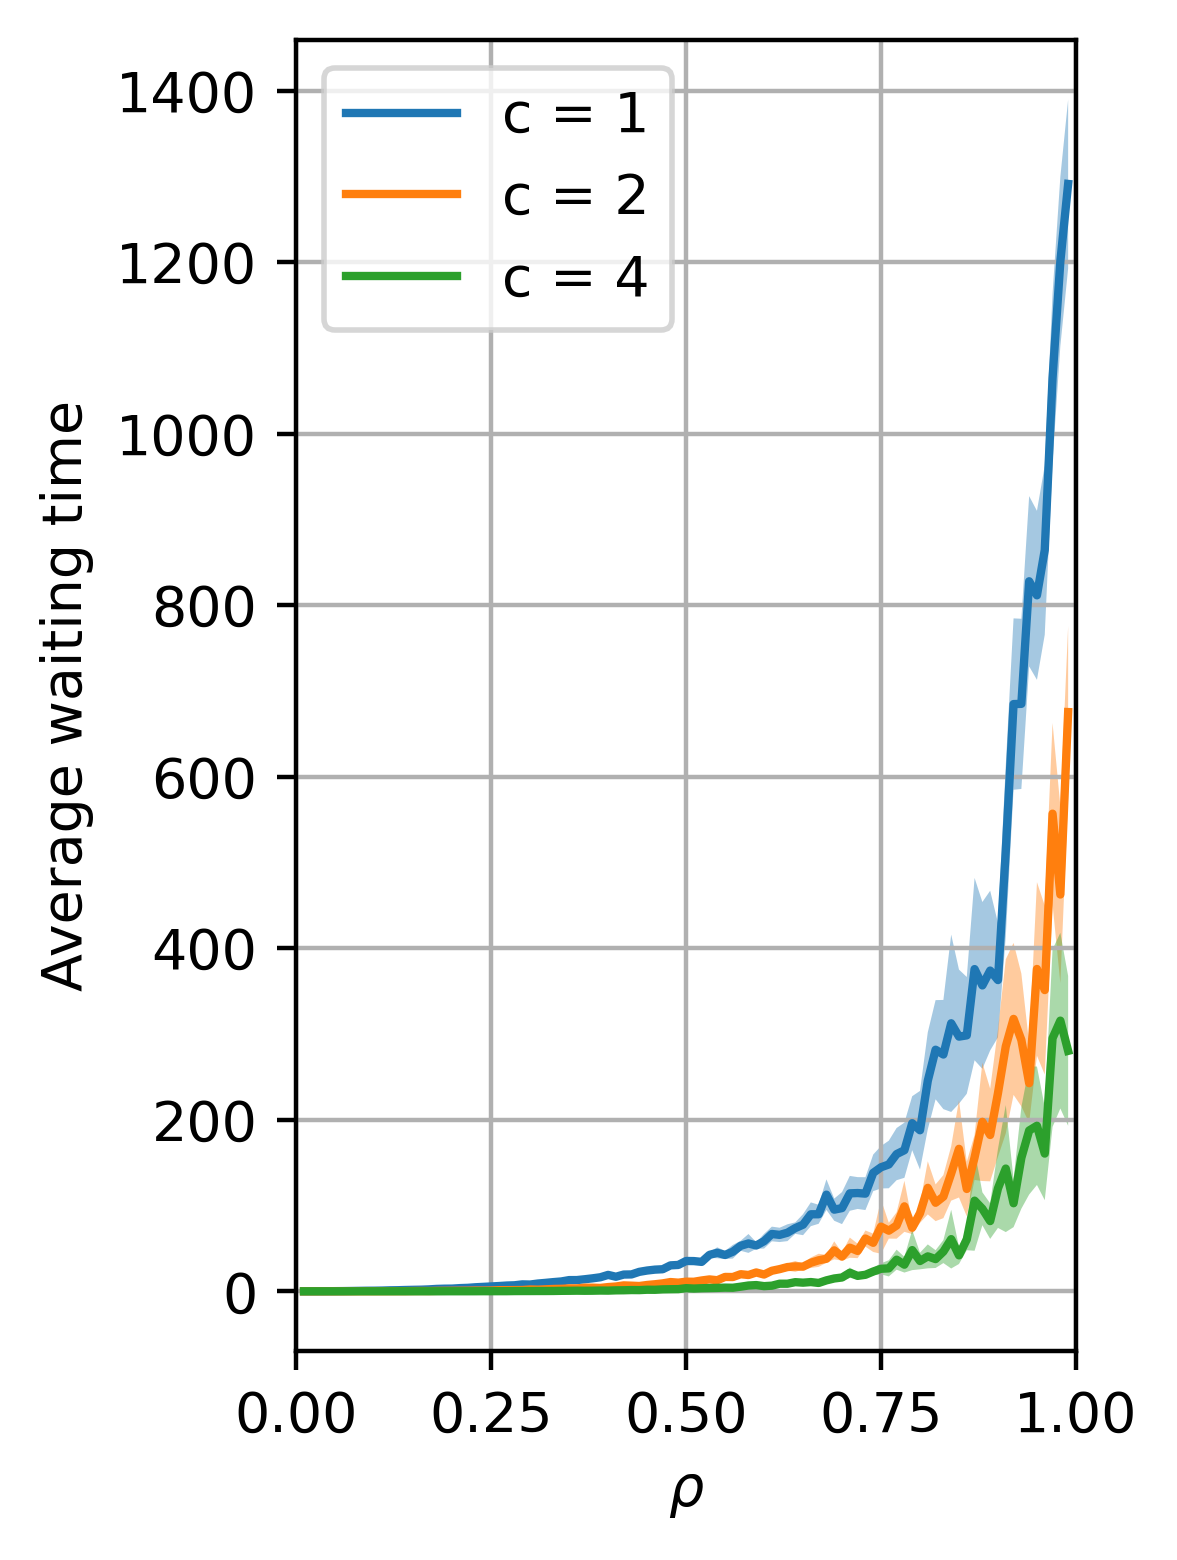

In [99]:
#Q4_tail
#Q4_markov
#Q4_deter

plt.figure(figsize=(3,4),dpi=400)

for num_servers, values in Q4_markov.items():
    x = values['x']
    waitingtimes = values['waitingtimes']
    confidence_waitingtime = np.array(values['confidences'])

    plt.plot(x, waitingtimes, label=f'c = {num_servers}')
    plt.fill_between(x, waitingtimes - confidence_waitingtime, waitingtimes + confidence_waitingtime, alpha=0.4)

plt.xlabel('$\\rho$')
plt.ylabel("Average waiting time")

#plt.title('FIFO')
#plt.xticks([rhos[0],rhos[-1]])
plt.xlim([0,1])
#plt.ylim([0,1200])
plt.legend()
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
plt.savefig('Q4_markov.png')


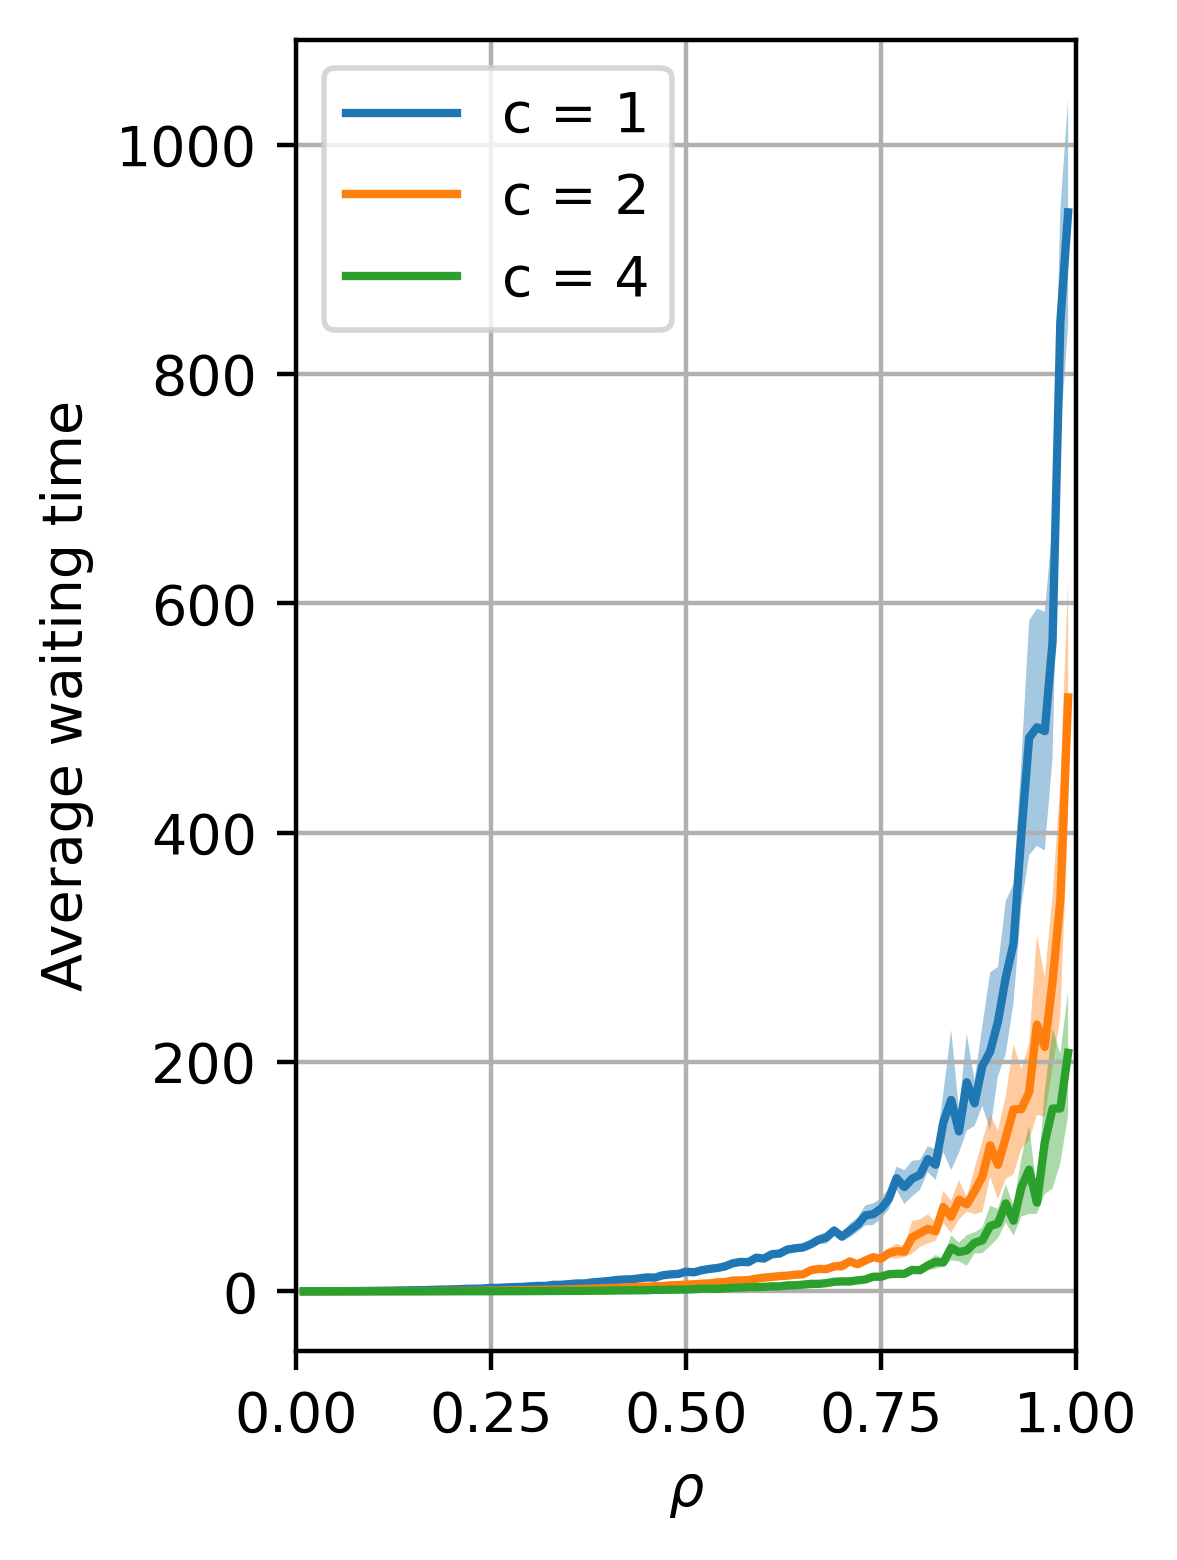

In [100]:
#Q4_tail
#Q4_markov
#Q4_deter

plt.figure(figsize=(3,4),dpi=400)

for num_servers, values in Q4_deter.items():
    x = values['x']
    waitingtimes = values['waitingtimes']
    confidence_waitingtime = np.array(values['confidences'])

    plt.plot(x, waitingtimes, label=f'c = {num_servers}')
    plt.fill_between(x, waitingtimes - confidence_waitingtime, waitingtimes + confidence_waitingtime, alpha=0.4)

plt.xlabel('$\\rho$')
plt.ylabel("Average waiting time")

#plt.title('FIFO')
#plt.xticks([rhos[0],rhos[-1]])
plt.xlim([0,1])
#plt.ylim([0,1200])
plt.legend()
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
plt.savefig('Q4_deter.png')


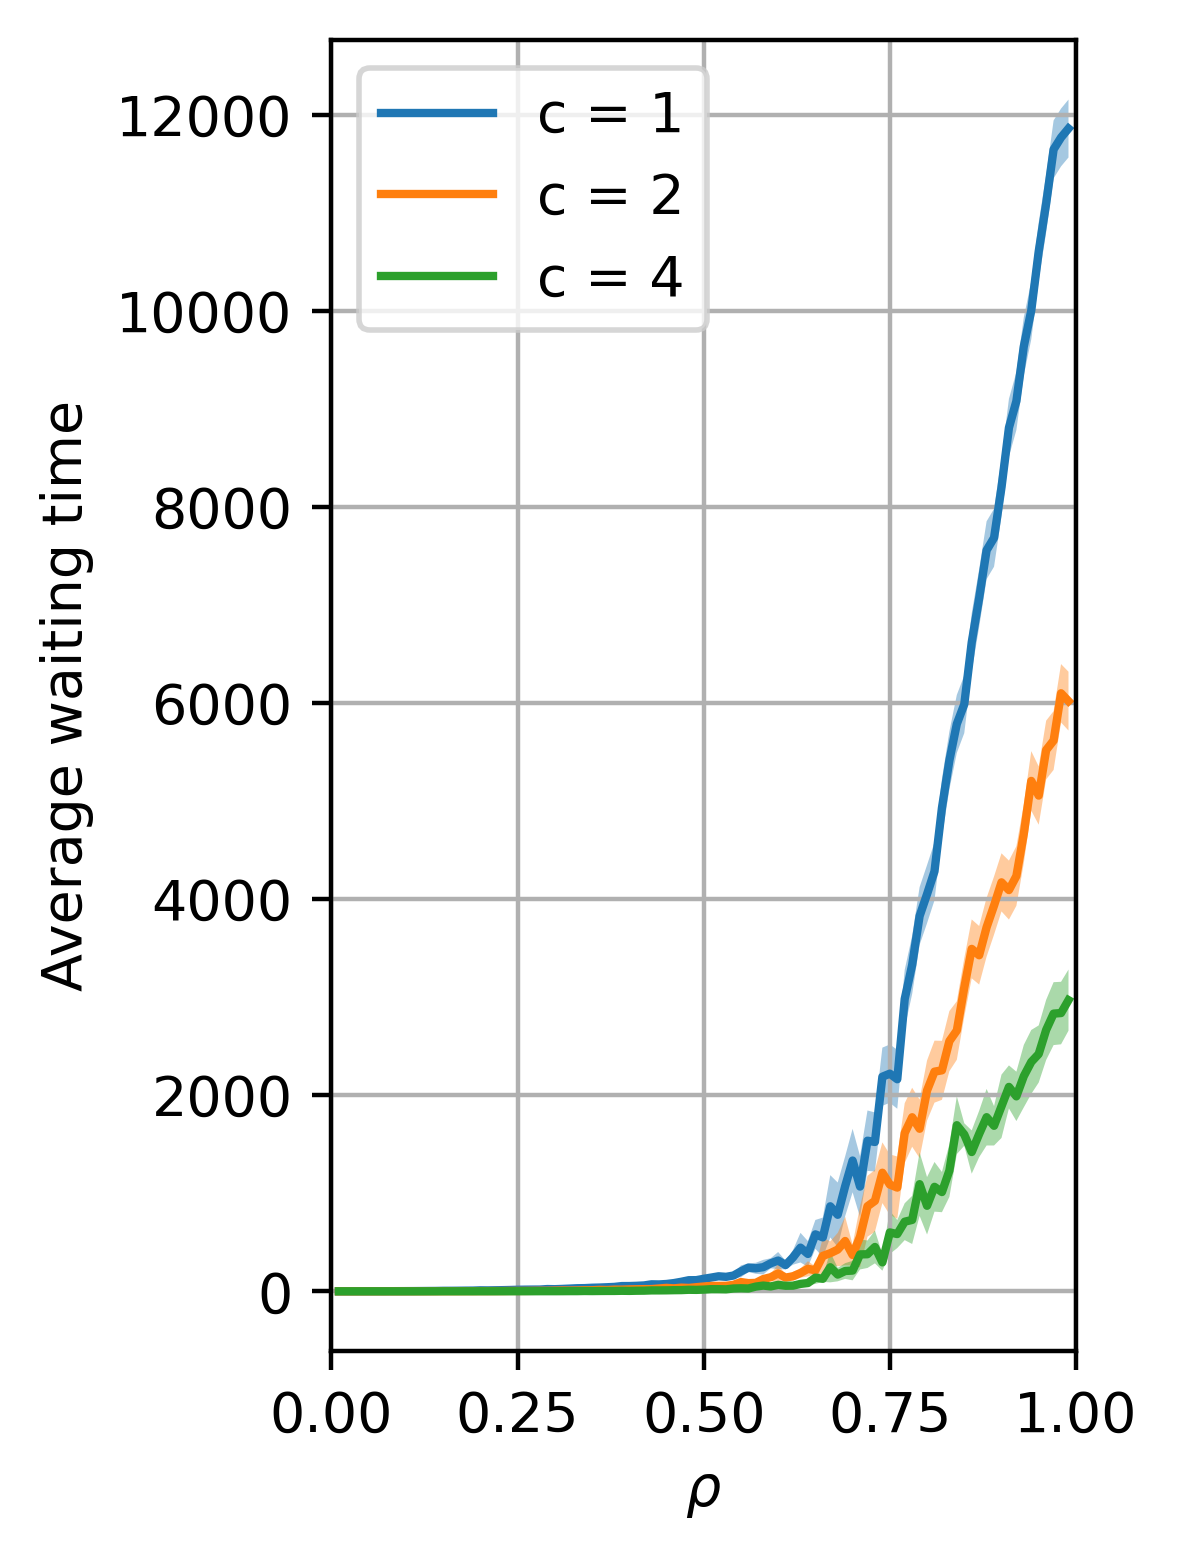

In [101]:
#Q4_tail
#Q4_markov
#Q4_deter

plt.figure(figsize=(3,4),dpi=400)

for num_servers, values in Q4_tail.items():
    x = values['x']
    waitingtimes = values['waitingtimes']
    confidence_waitingtime = np.array(values['confidences'])

    plt.plot(x, waitingtimes, label=f'c = {num_servers}')
    plt.fill_between(x, waitingtimes - confidence_waitingtime, waitingtimes + confidence_waitingtime, alpha=0.4)

plt.xlabel('$\\rho$')
plt.ylabel("Average waiting time")

#plt.title('FIFO')
#plt.xticks([rhos[0],rhos[-1]])
plt.xlim([0,1])
#plt.ylim([0,1200])
plt.legend()
plt.legend(loc='upper left')
plt.grid()
plt.tight_layout()
plt.savefig('Q4_tail.png')


{'1': {'x': '[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]', 'waitingtimes': '[0.0, 0.0036059881649750554, 0.016996963457264105, 0.04213758094049376, 0.08750649350553748, 0.16776975518707332, 0.30179382605693744, 0.5334379455159559, 1.0502854236741144, 2.3138492685645735]', 'confidences': '[0.0, 0.00015253578255629215, 0.0005510723375159515, 0.0011993316664371562, 0.002444969967882251, 0.00572004184573428, 0.01114407244705147, 0.02341830813884569, 0.07959839197164806, 0.20153820923668322]', 'n_simulations': '[51, 51, 51, 51, 51, 51, 51, 51, 51, 51]'}, '2': {'x': '[0.  0.1 0.2 0.3 0.4 0.5 0.6 0.7 0.8 0.9]', 'waitingtimes': '[0.0, 0.0004188486444644748, 0.0031098726498070255, 0.010899043380974693, 0.026689764510597305, 0.056973839829617796, 0.1170750601466246, 0.22643187265836232, 0.45525984709368783, 1.1815786196716112]', 'confidences': '[0.0, 3.1834798114819494e-05, 0.00019375885424198028, 0.00048200422979362734, 0.0012688868412012093, 0.0021630946178704796, 0.0050219975242205075, 0.011194

ValueError: Unrecognized character [ in format string

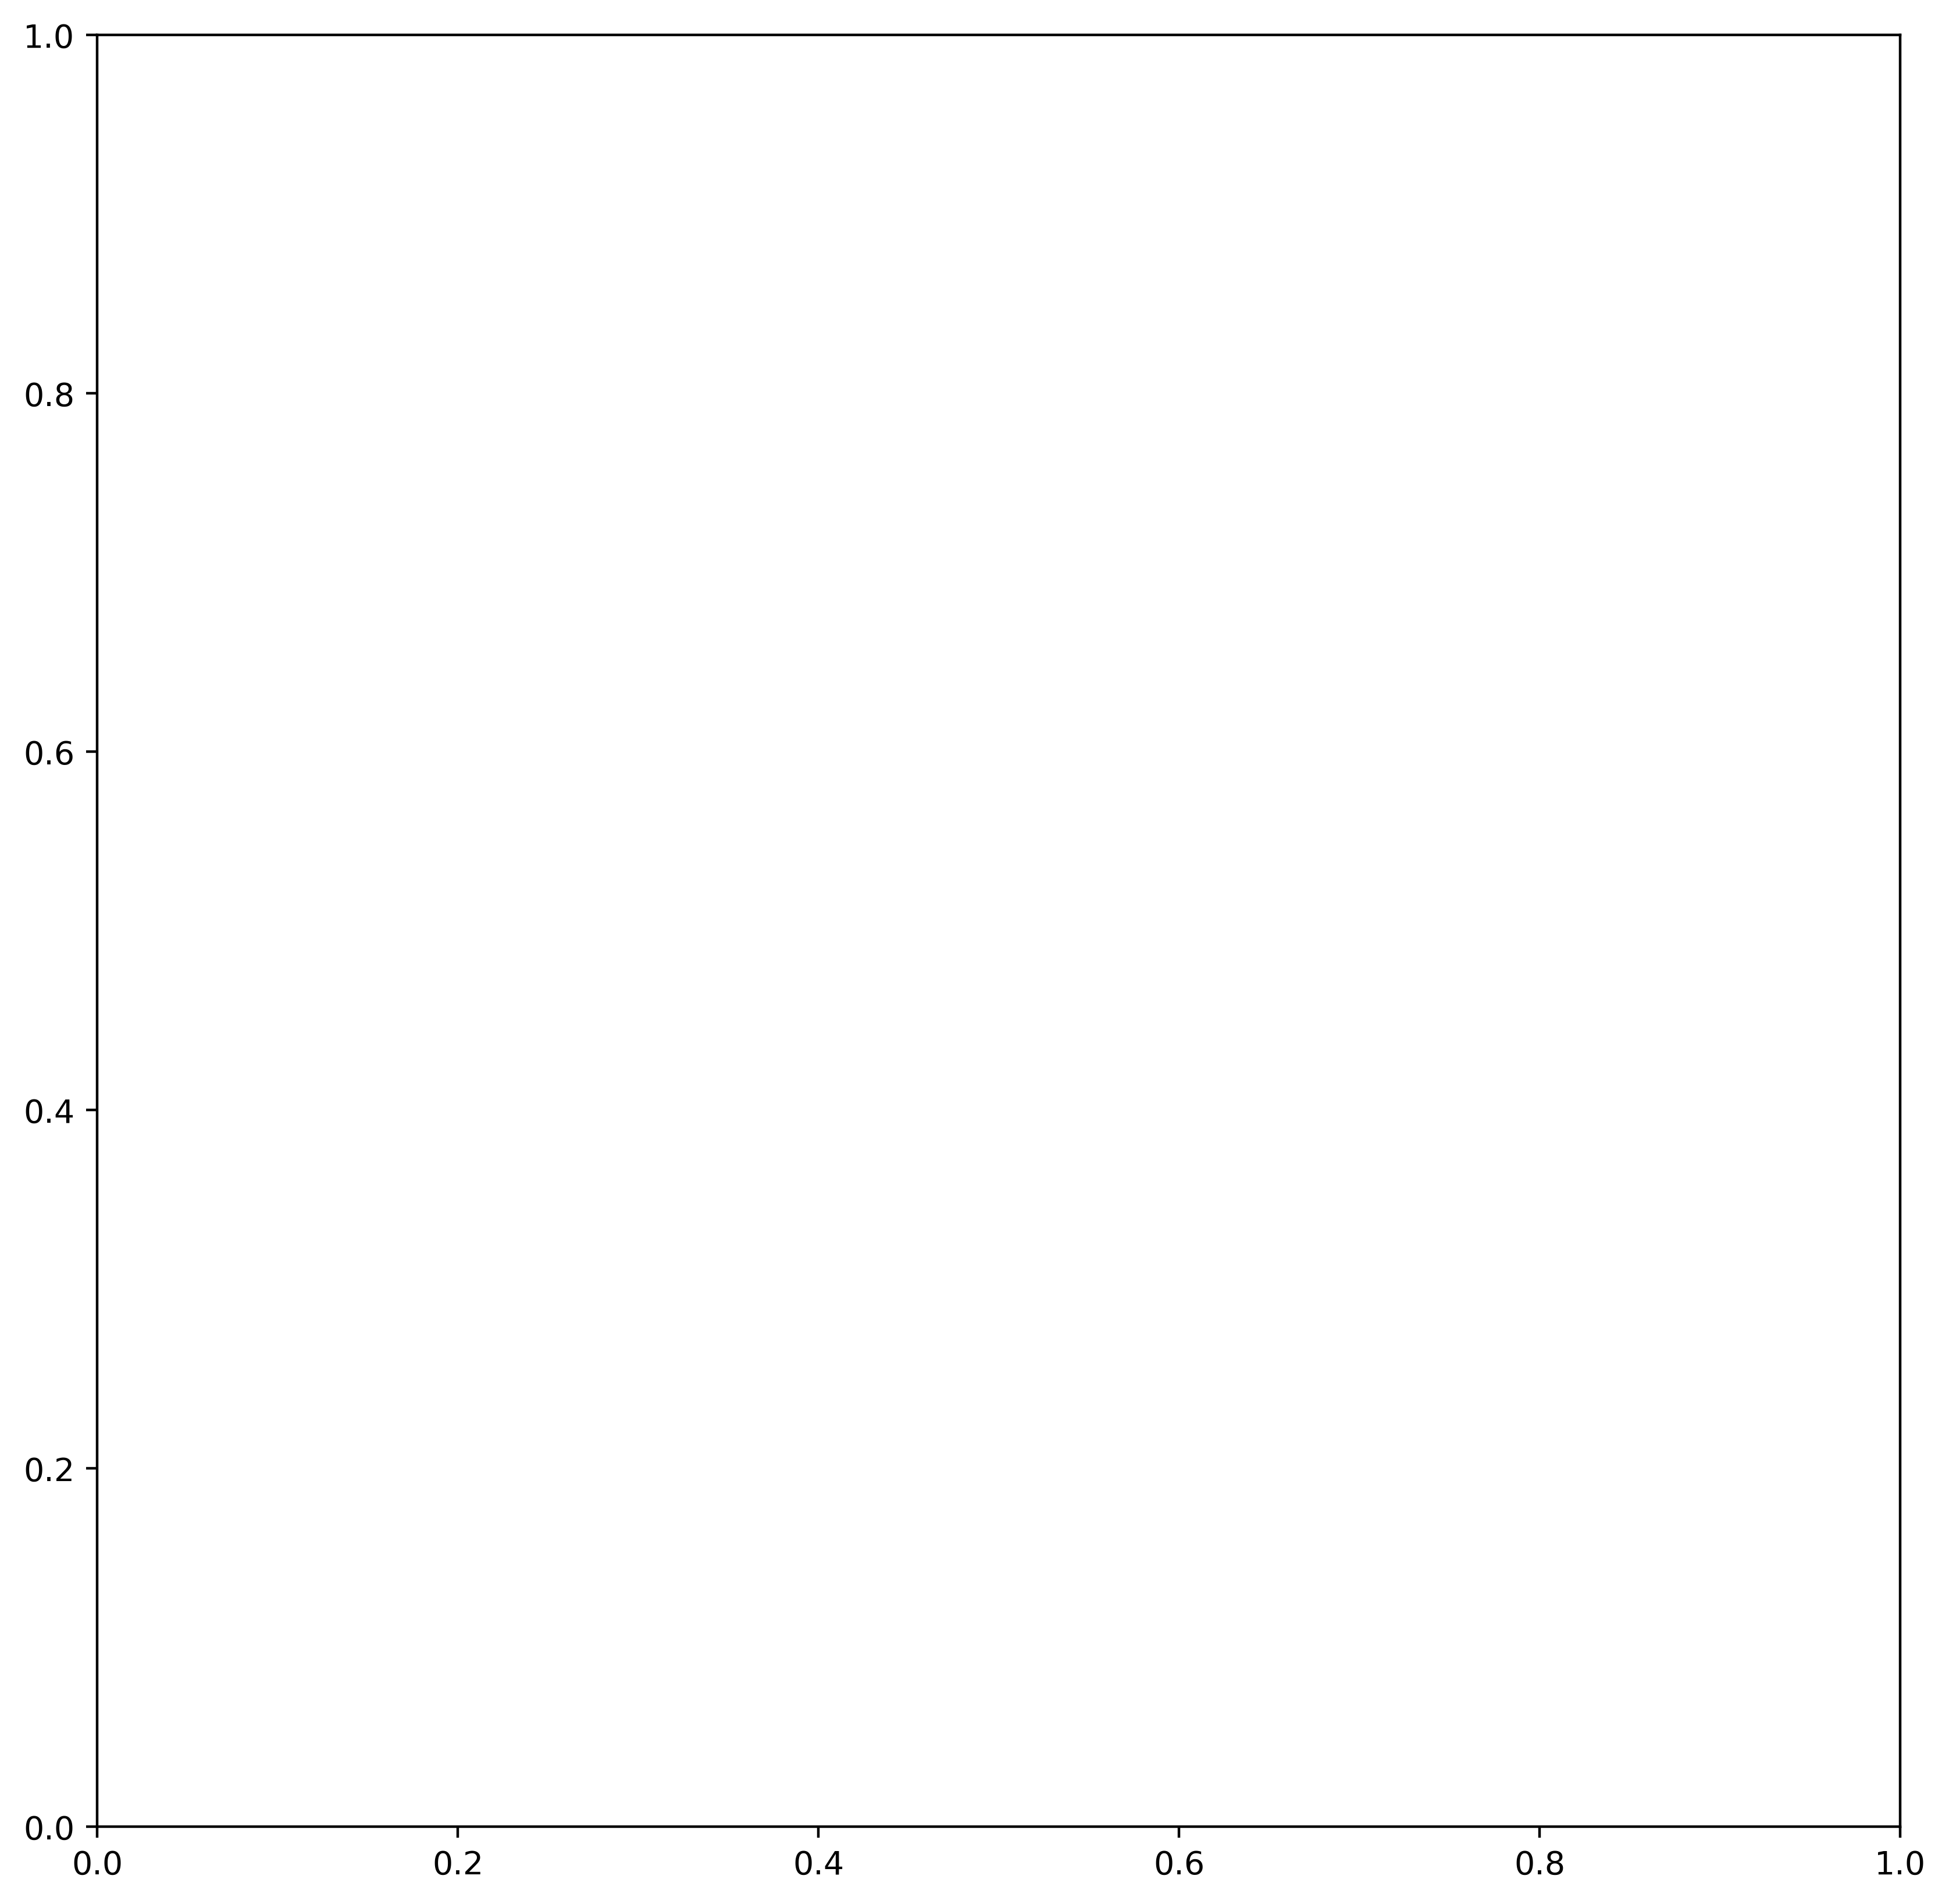

In [33]:
# Plot deter,long,markov

#print(deter['1']['x'])
#waitingtimes
#confidences
#n_simulations


def plot_waitingtimes(data, axs):
    """Plots the average waiting times with different servers and different system loads."""
    
    for num_servers, values in data.items():
        x = values['x']
        waitingtimes = values['waitingtimes']
        confidence_waitingtime = np.array(values['confidences'])

        print(x)
        print(waitingtimes)

        axs.plot(x, waitingtimes)   #, label=f'Number of servers = {num_servers}')
        
        #axs.fill_between(x, waitingtimes - confidence_waitingtime, waitingtimes + confidence_waitingtime, alpha=0.4)

    axs.set_xlabel("System load")
    axs.set_ylabel("Average waiting time")
    axs.legend()


fig, axs = plt.subplots(dpi=400, figsize = (10,10))
data = deter

print(data)
plot_waitingtimes(data, axs)

In [ ]:
# Save